In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)

<module 'libs.params' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/params.py'>

In [2]:
import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
pd.set_option('display.max_columns', None)

import numpy as np
import glob
import os
import json

import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML
import seaborn as sns

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)


/usr/bin/python


[main] Found existing base CSV: dfs/AAPL_1_base.csv


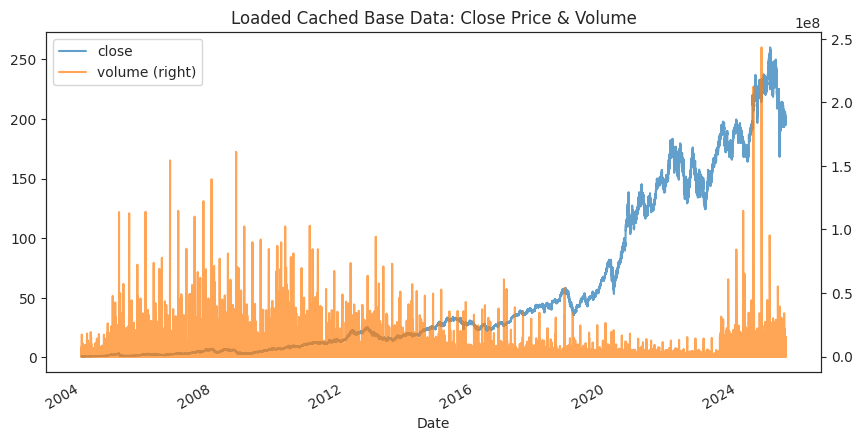

open        high         low       close  \
2004-01-02 09:00:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:01:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:02:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:03:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:04:00    0.764286    0.764286    0.764286    0.764286   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  196.680000  196.860000  196.630000  196.815000   
2025-06-18 20:57:00  196.810000  196.940000  196.560000  196.675000   
2025-06-18 20:58:00  196.675000  196.740000  196.630000  196.670000   
2025-06-18 20:59:00  196.680000  196.750000  196.240000  196.240000   
2025-06-18 21:00:00  196.580000  196.650000  196.080000  196.540000   

                         volume         ask         bid  
2004-01-02 09:00:00     28000.0    0.764668    0.763904  
2004-01-02 09:01:00     28000.0    0.764668    0.763904  
2004-01-02 09:02:00     28000.0    0.764668    0.763904  
2004-01-02 09:03:00     28000.0    0.764668    0.763904  
2004-01-02 09:04:00     28000.0    0.764668    0.763904  
...                         ...         ...         ...  
2025-06-18 20:56:00    385695.0  196.913400  196.716600  
2025-06-18 20:57:00    460630.0  196.773300  196.576700  
2025-06-18 20:58:00    525245.0  196.768300  196.571700  
2025-06-18 20:59:00   2075503.0  196.338100  196.141900  
2025-06-18 21:00:00  15600625.0  196.638300  196.441700  

[3893400 rows x 7 columns]

In [3]:
base_csv = params.base_csv

if not params.createCSVbase and os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] Re-creating base CSV; running process_splits …")
    df_raw = trades.process_splits(
        folder              = params.stocks_folder,
        ticker              = params.ticker,
        bidask_spread_pct   = params.bidask_spread_pct
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                = df_raw,
        sess_premark      = params.sess_premark,
        sess_start        = params.sess_start,
        sess_end          = params.sess_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def saveDF_checkDAY(
    df: pd.DataFrame,
    best_optuna_params: Dict
) -> pd.DataFrame:
    """
    1) Slice df to the month in params.month_to_check ("YYYY-MM").
    2) Run the optimized pipeline over that month’s data:
       - The pipeline itself will group and simulate day by day.
       - Plot each day’s trades & equity.
       - Print per-day performance.
    3) If params.createCSVsign:
       • Rerun pipeline on the full df, aggregate & plot.
       • Save the full-run signals CSV.
       • Return the full-run DataFrame.
    4) Otherwise return the month’s concatenated signals/actions DataFrame.
    """
    # 1) Filter to the chosen month
    month_str = params.month_to_check    # e.g. "2023-09"
    print(f"\n=== Running pipeline for month {month_str} ===")

    # mask all rows whose index formatted as "YYYY-MM" equals month_to_check
    df_period = df[df.index.strftime("%Y-%m") == month_str].copy()
    if df_period.empty:
        print("No market data for this month; returning empty DataFrame.")
        return pd.DataFrame()

    # 2) Run pipeline on entire month slice
    result_by_day = trades.run_trading_pipeline(
        df           = df_period,
        col_signal   = "signal",
        col_action   = "signal_action",
        **best_optuna_params
    )
    if not result_by_day:
        print("No trades generated in this period; returning empty DataFrame.")
        return pd.DataFrame()

    # Unpack per-day results for plotting & stats
    month_frames = []
    month_stats  = []
    for day, (df_day, trades_day, perf_day) in result_by_day.items():
        print(f"-------------------------------------------------------------------------------------------------------------------------------------------------")
        plots.plot_trades(
            df                 = df_day,
            col_signal1        = "signal",
            col_signal2        = False,
            col_action         = "signal_action",
            trades             = trades_day,
            buy_threshold      = best_optuna_params["buy_threshold"],
            performance_stats  = perf_day,
            start_plot         = params.sess_start
        )
        for k, v in perf_day.items():
            print(f"  {k}: {v}")

        month_frames.append(df_day)
        month_stats.append(perf_day)

    df_month = pd.concat(month_frames).sort_index()
    plots.aggregate_performance(month_stats, df_month)
    
    # If not saving full-run CSV, just return the month’s results
    if not params.createCSVsign:
        return df_month

    # 3) Full-run backtest (same as before)
    print("\n******************** Running pipeline on full dataset ********************")
    full_results = trades.run_trading_pipeline(
        df           = df,
        col_signal   = "signal",
        col_action   = "signal_action",
        **best_optuna_params
    )

    # Build combined DF & perf list
    daily_frames = [res[0] for res in full_results.values()]
    df_all       = pd.concat(daily_frames).sort_index()
    perf_all     = [res[2] for res in full_results.values()]
    plots.aggregate_performance(perf_all, df_all)

    # Test-period slice & performance
    all_days  = df_all.index.normalize().unique()
    cutoff    = int(len(all_days) * (params.train_prop + params.val_prop))
    test_days = all_days[cutoff:]
    df_test   = df_all[df_all.index.normalize().isin(test_days)]
    perf_test = [
        stats
        for day, (_, _, stats) in full_results.items()
        if pd.Timestamp(day).normalize() in test_days
    ]
    plots.aggregate_performance(perf_test, df_test)

    # Save the full-run signals CSV
    print(f"\nSaving full-run signals to {params.sign_csv} …")
    df_all.to_csv(params.sign_csv)
    print("CSV saved.")

    return df_all


best_optuna_value: 0.6506474074074075
best_optuna_params: {'min_prof_thr': 0.02816671881765163, 'max_down_prop': 0.36686173478909995, 'gain_tightening_factor': 14.255693038604218, 'merging_retracement_thr': 0.4504597797483987, 'merging_time_gap_thr': 3.118887875648426, 'tau_time': 14, 'tau_dur': 198, 'trailing_stop_pct': 0.0422898528107775, 'buy_threshold': 0.35982165053364656, 'smoothing_window': 3}

=== Running pipeline for month 2023-10 ===
Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 3.322 ) & generating trade actions …


Simulating trading days: 100%|██████████| 22/22 [00:00<00:00, 37.01day/s]


-------------------------------------------------------------------------------------------------------------------------------------------------


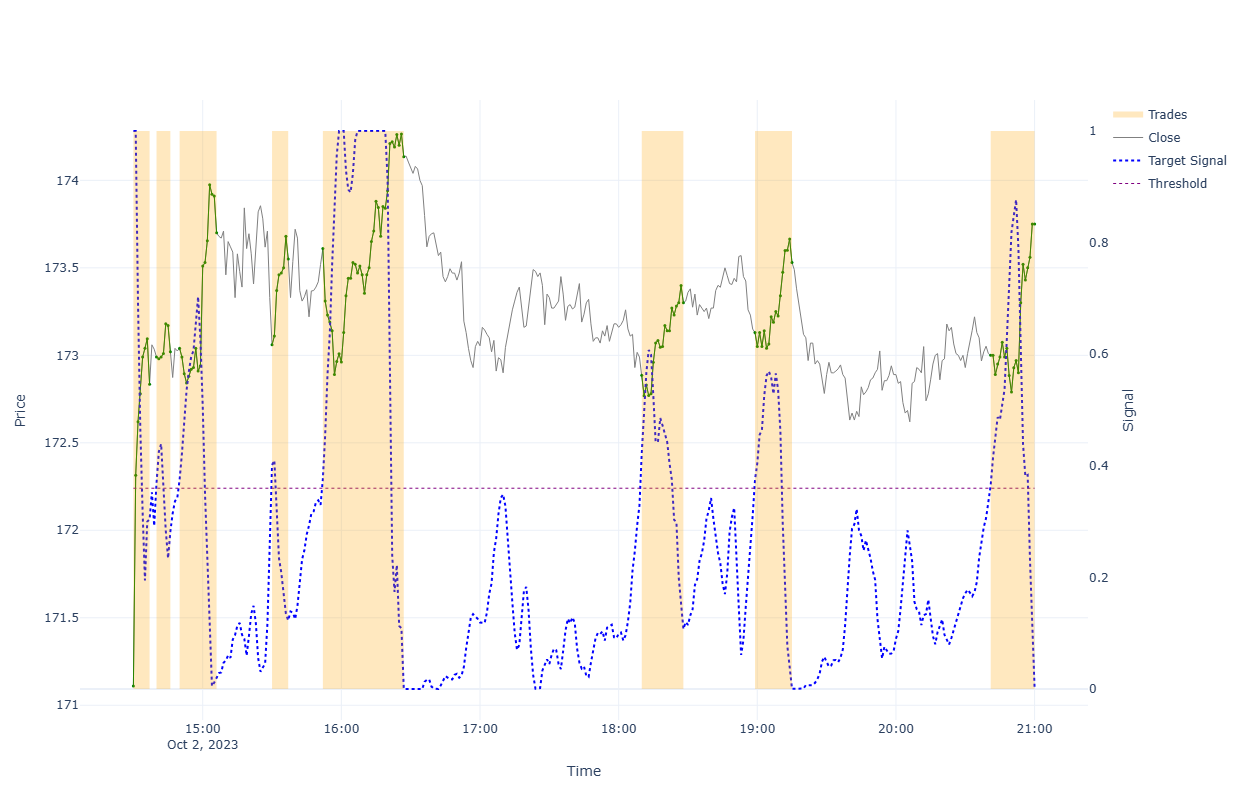

  Buy & Hold Return ($): 2.467
  Strategy Return ($): 3.609
  Trades Returns ($): [1.553, -0.144, 0.486, 0.317, 0.351, 0.242, 0.227, 0.576]
-------------------------------------------------------------------------------------------------------------------------------------------------


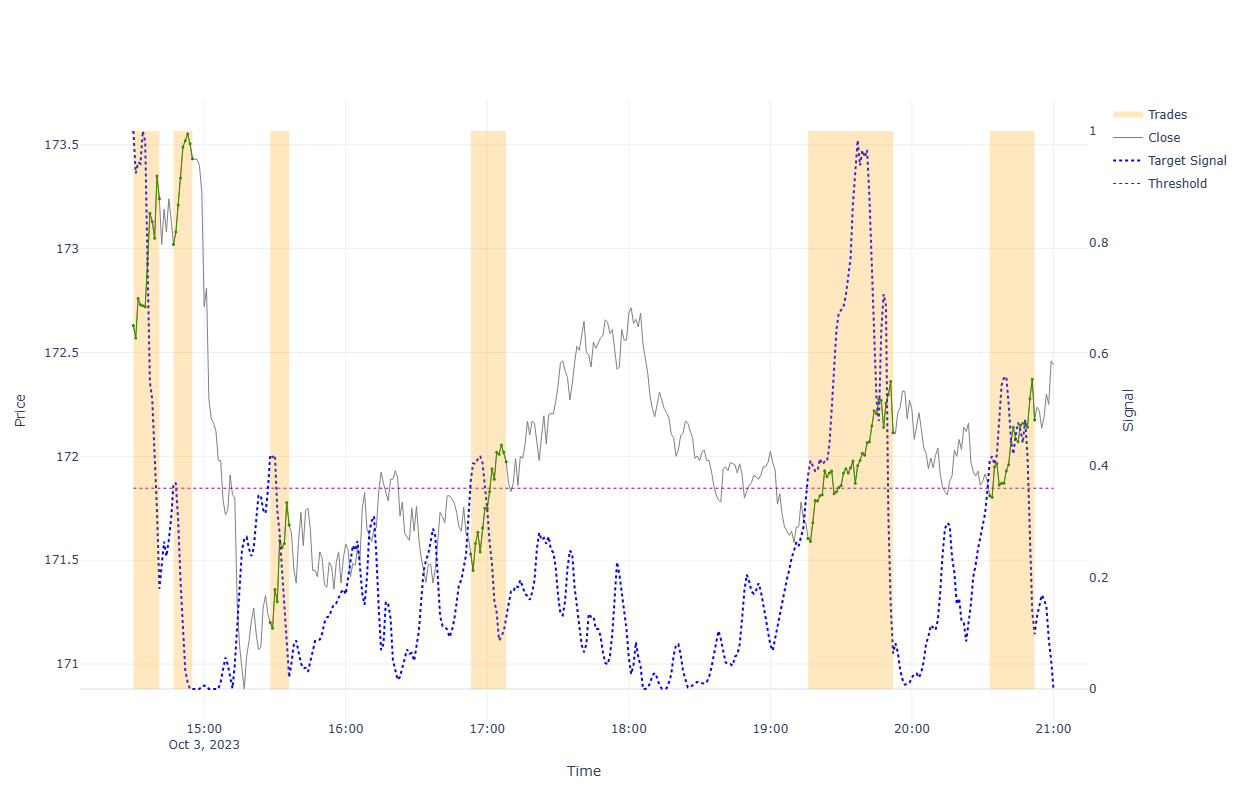

  Buy & Hold Return ($): -0.362
  Strategy Return ($): 1.778
  Trades Returns ($): [0.437, 0.241, 0.298, 0.273, 0.337, 0.193]
-------------------------------------------------------------------------------------------------------------------------------------------------


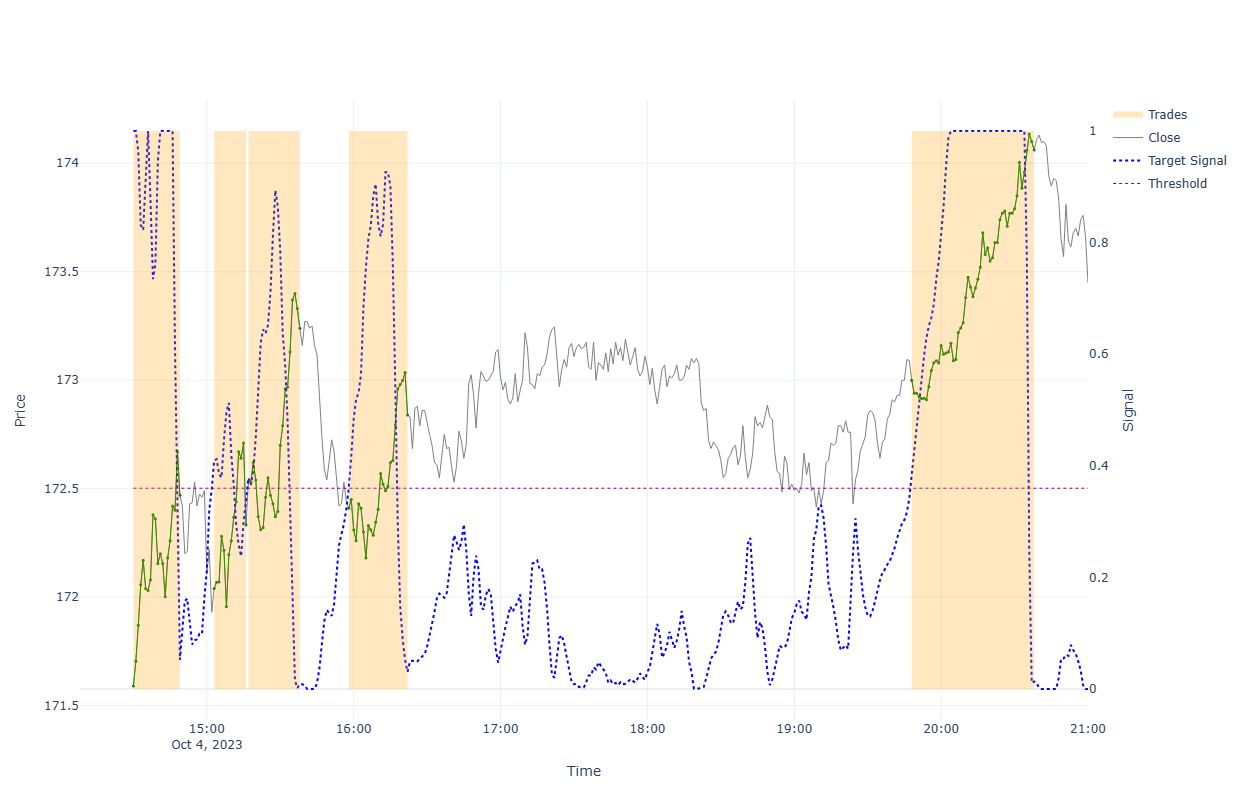

  Buy & Hold Return ($): 1.687
  Strategy Return ($): 2.51
  Trades Returns ($): [0.707, 0.12, 0.537, 0.257, 0.888]
-------------------------------------------------------------------------------------------------------------------------------------------------


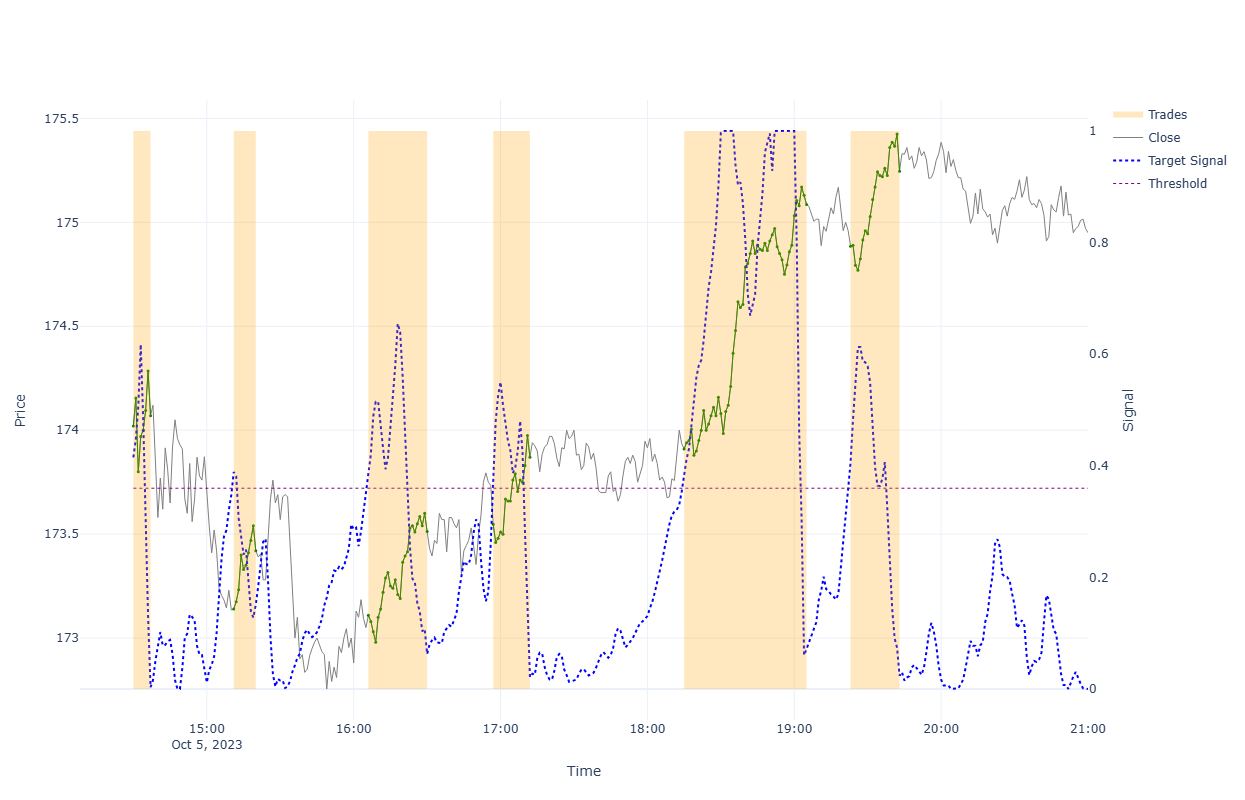

  Buy & Hold Return ($): 0.756
  Strategy Return ($): 1.549
  Trades Returns ($): [-0.124, 0.107, 0.23, 0.149, 1.002, 0.185]
-------------------------------------------------------------------------------------------------------------------------------------------------


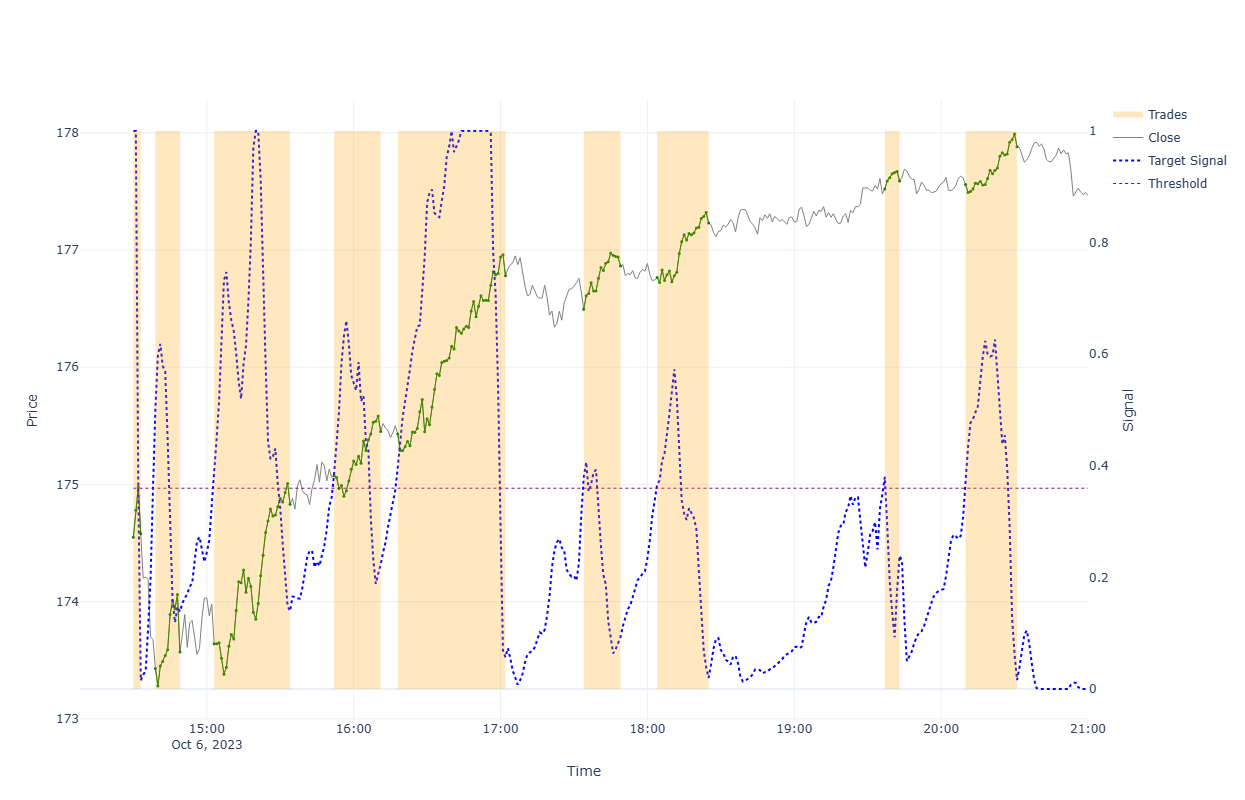

  Buy & Hold Return ($): 2.739
  Strategy Return ($): 2.73
  Trades Returns ($): [-0.145, -0.033, 1.016, 0.201, 1.174, 0.192, 0.288, -0.108, 0.144]
-------------------------------------------------------------------------------------------------------------------------------------------------


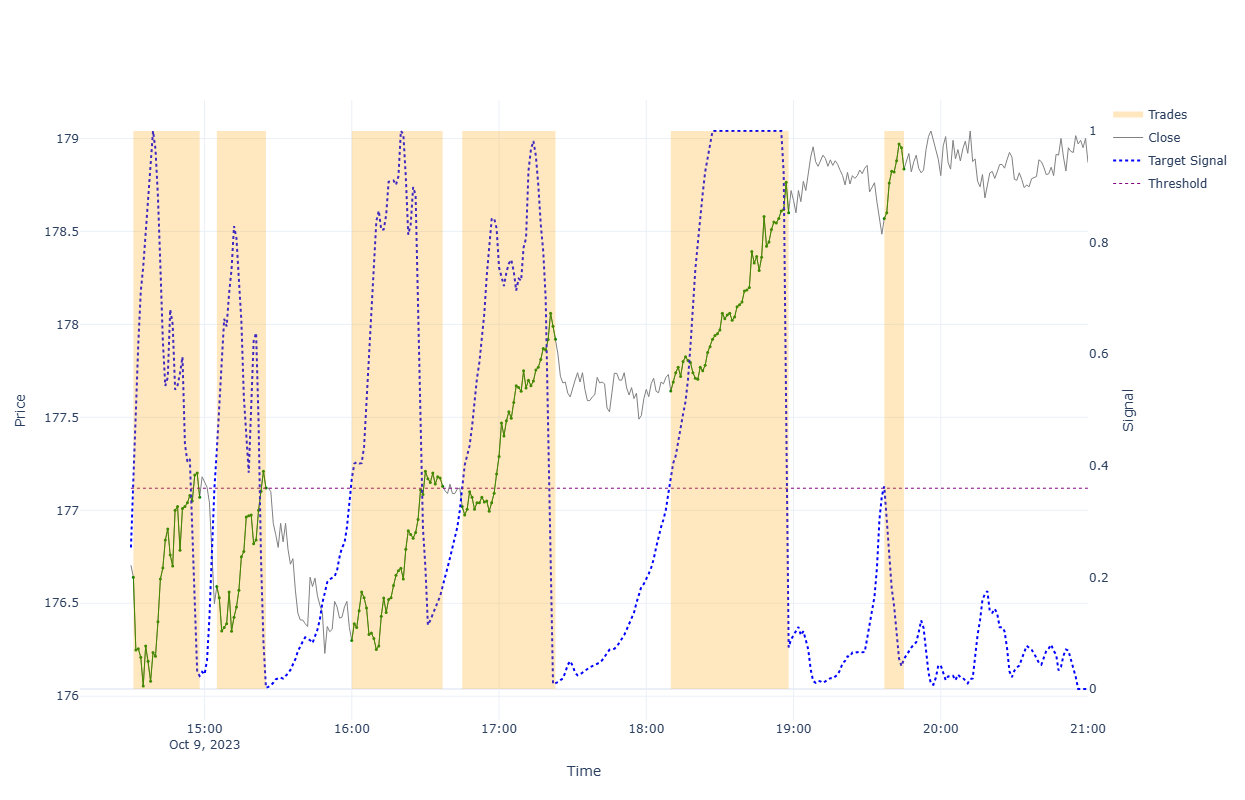

  Buy & Hold Return ($): 1.988
  Strategy Return ($): 2.849
  Trades Returns ($): [0.253, 0.353, 0.653, 0.723, 0.78, 0.086]
-------------------------------------------------------------------------------------------------------------------------------------------------


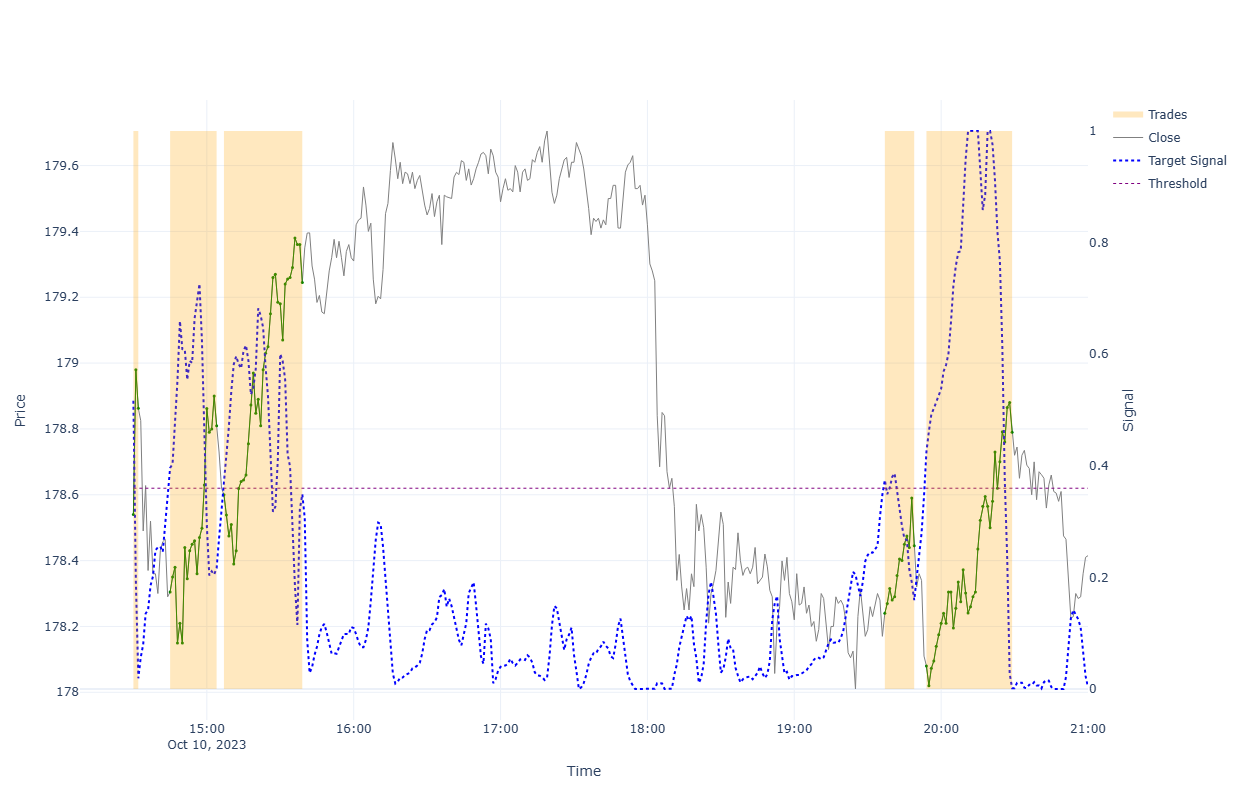

  Buy & Hold Return ($): -0.304
  Strategy Return ($): 1.495
  Trades Returns ($): [0.145, 0.326, 0.466, 0.027, 0.531]
-------------------------------------------------------------------------------------------------------------------------------------------------


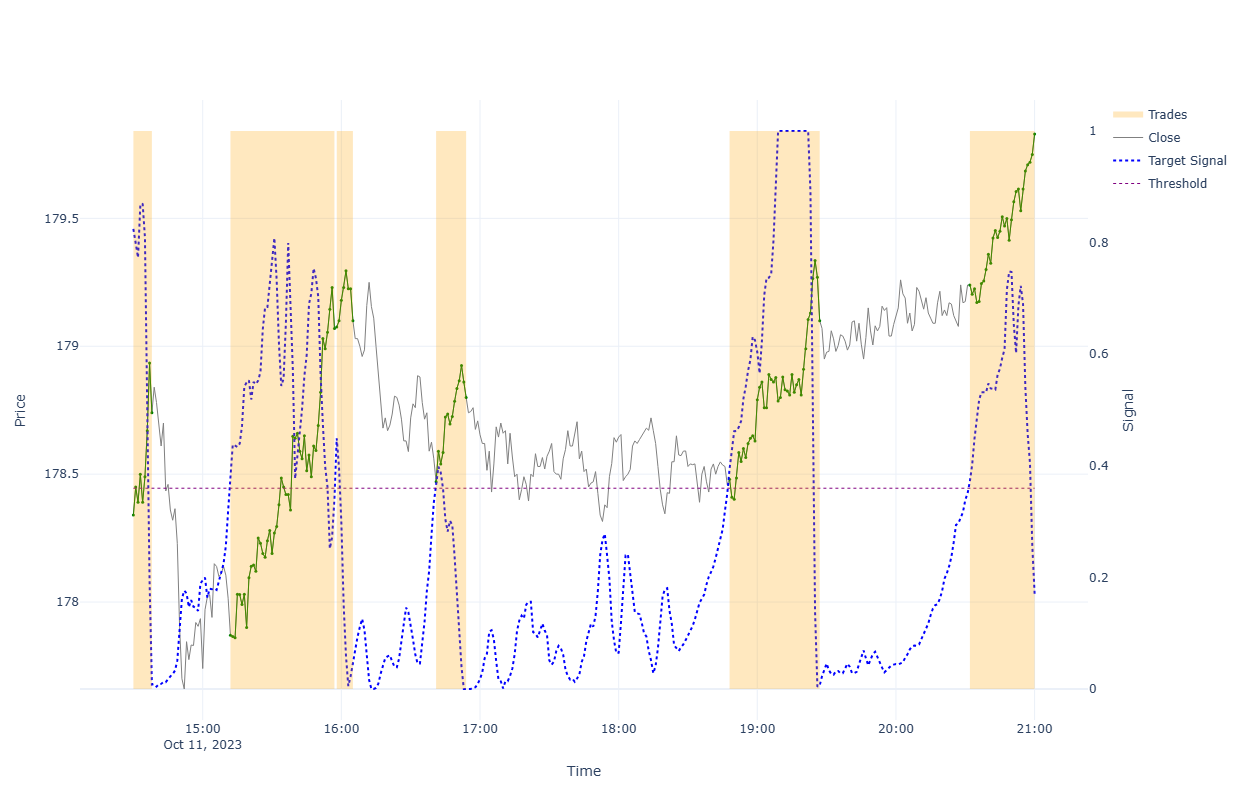

  Buy & Hold Return ($): 1.311
  Strategy Return ($): 2.092
  Trades Returns ($): [0.221, 1.021, -0.154, 0.152, 0.441, 0.411]
-------------------------------------------------------------------------------------------------------------------------------------------------


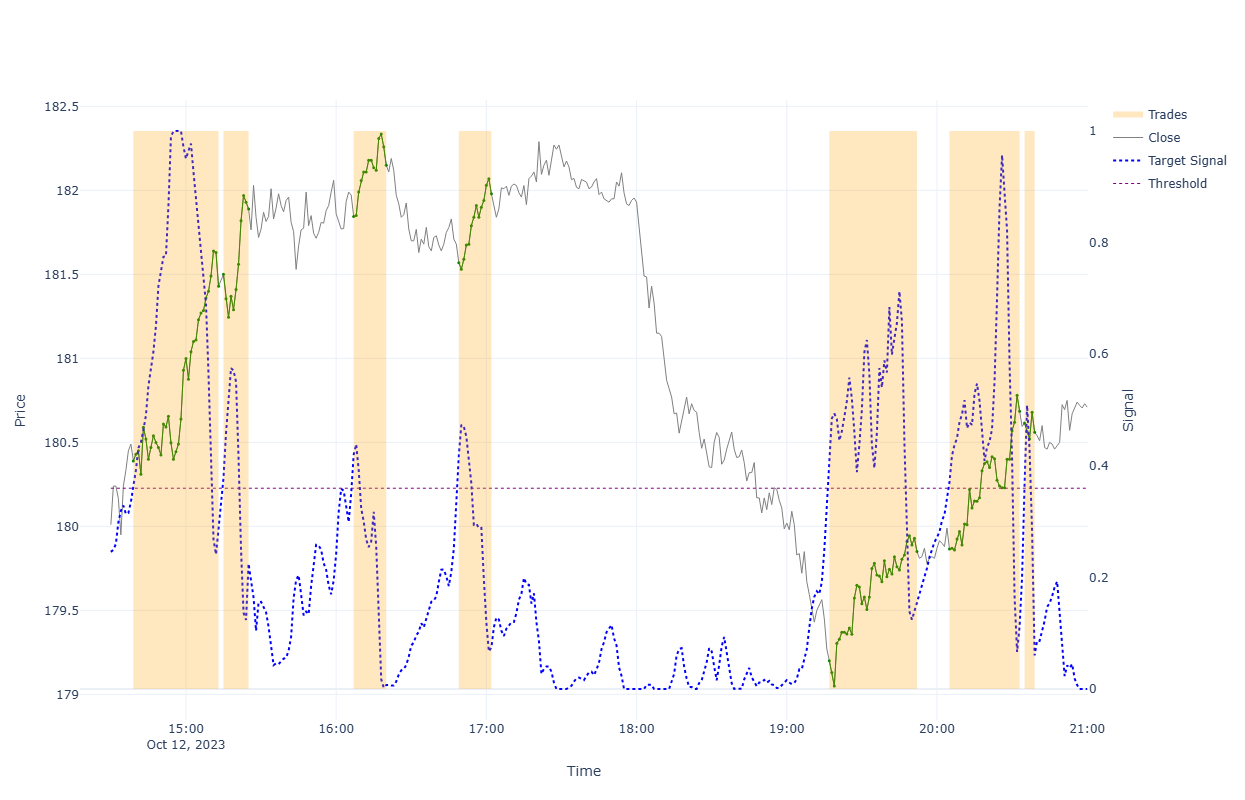

  Buy & Hold Return ($): 0.52
  Strategy Return ($): 2.294
  Trades Returns ($): [0.859, 0.209, 0.124, 0.229, 0.47, 0.641, -0.235]
-------------------------------------------------------------------------------------------------------------------------------------------------


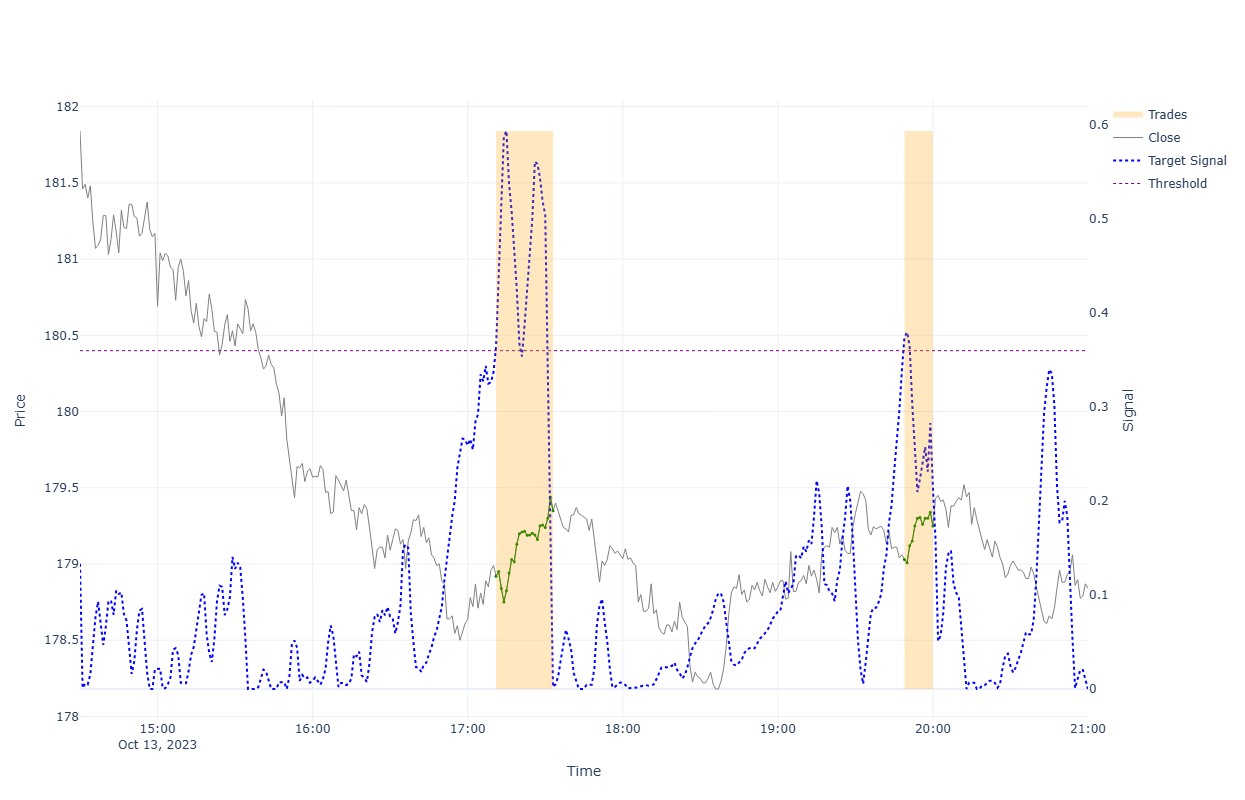

  Buy & Hold Return ($): -3.18
  Strategy Return ($): 0.292
  Trades Returns ($): [0.251, 0.041]
-------------------------------------------------------------------------------------------------------------------------------------------------


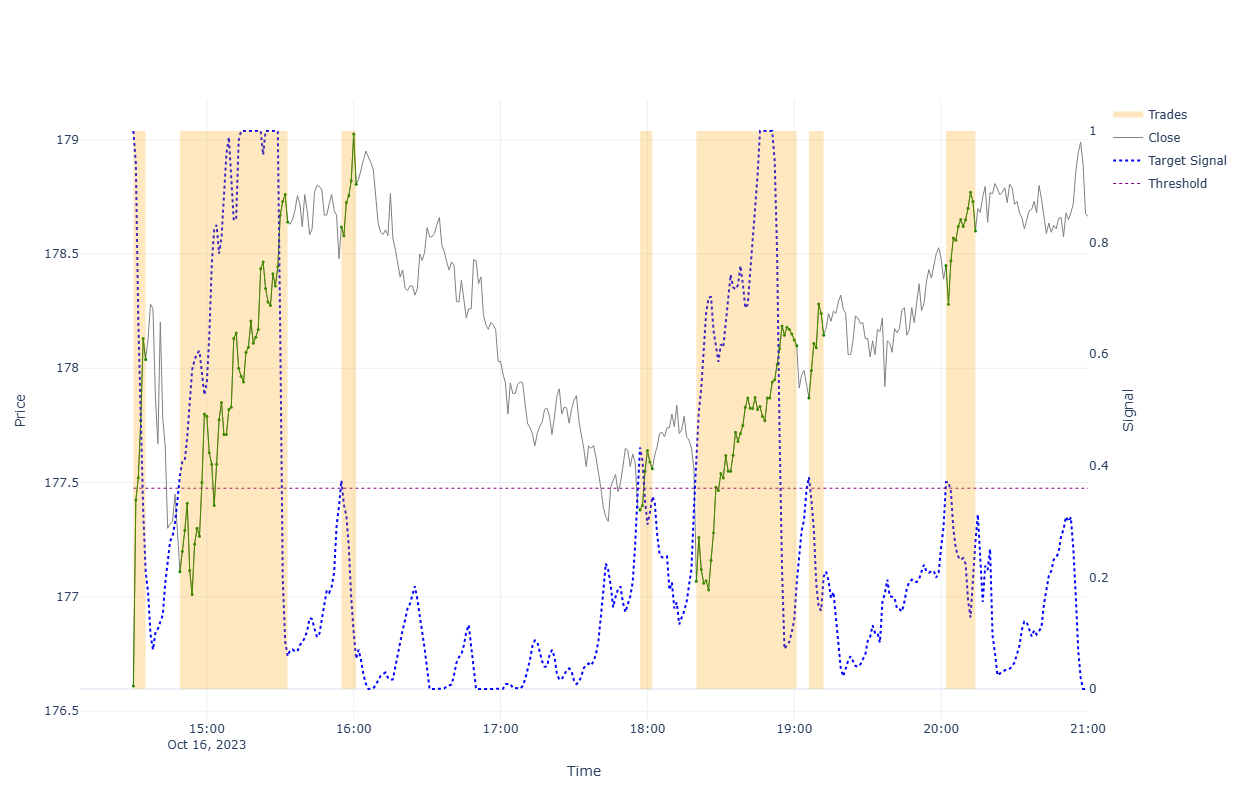

  Buy & Hold Return ($): 1.877
  Strategy Return ($): 3.535
  Trades Returns ($): [1.251, 1.352, 0.007, 0.002, 0.854, 0.098, -0.029]
-------------------------------------------------------------------------------------------------------------------------------------------------


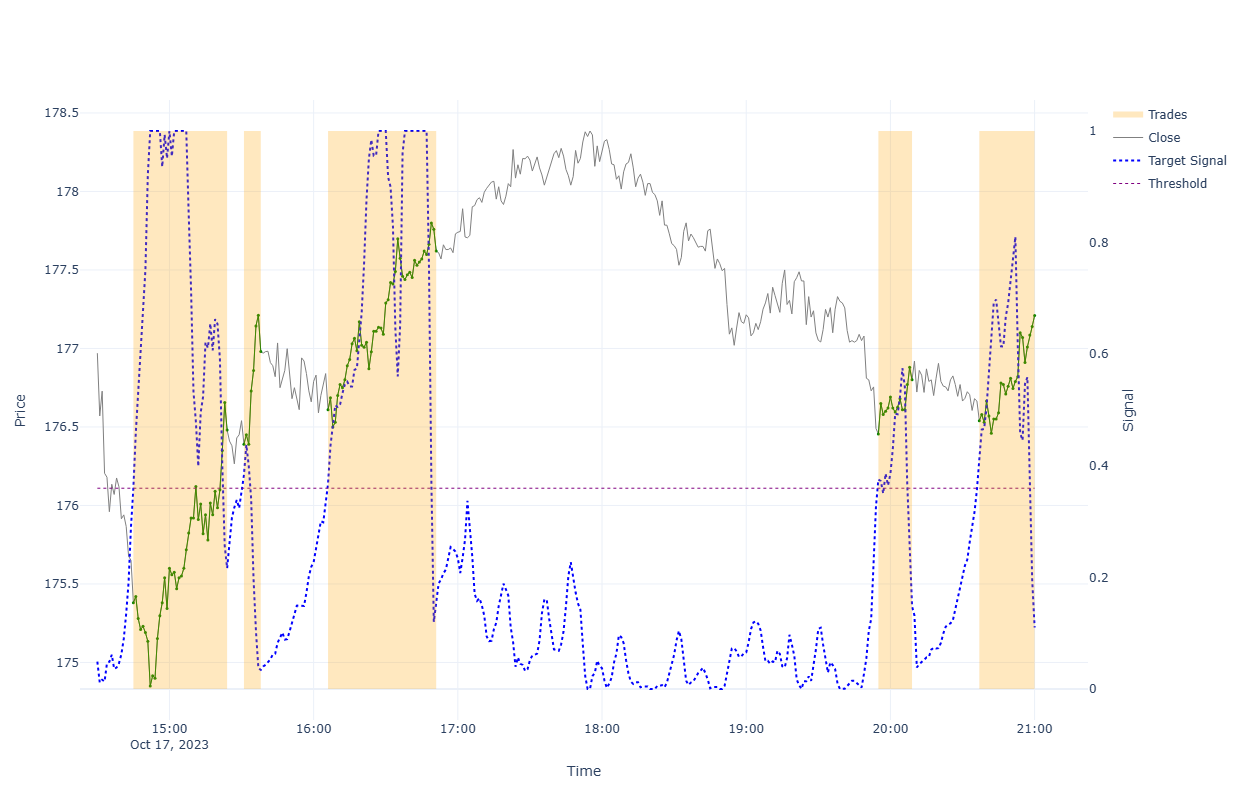

  Buy & Hold Return ($): 0.063
  Strategy Return ($): 2.832
  Trades Returns ($): [0.925, 0.413, 0.832, 0.168, 0.493]
-------------------------------------------------------------------------------------------------------------------------------------------------


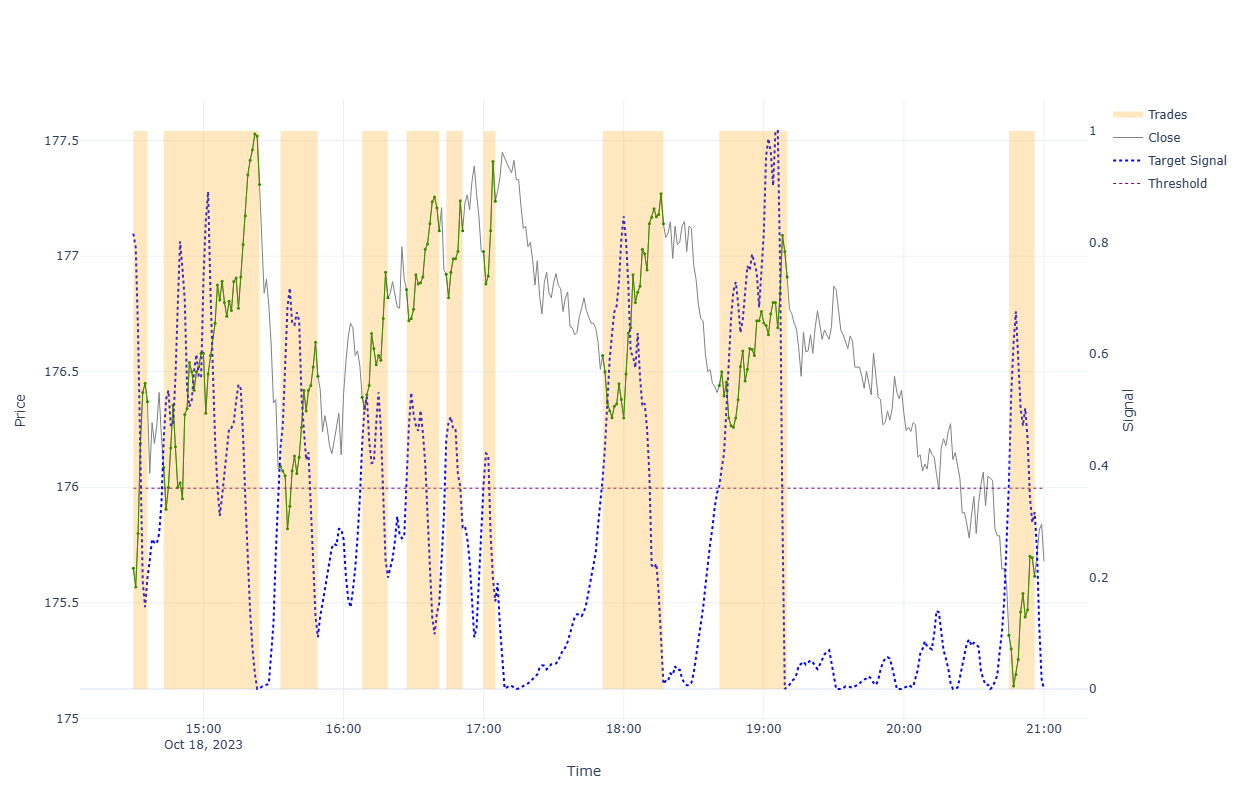

  Buy & Hold Return ($): -0.146
  Strategy Return ($): 2.954
  Trades Returns ($): [0.545, 1.048, 0.213, 0.254, 0.078, 0.011, 0.041, 0.394, 0.293, 0.079]
-------------------------------------------------------------------------------------------------------------------------------------------------


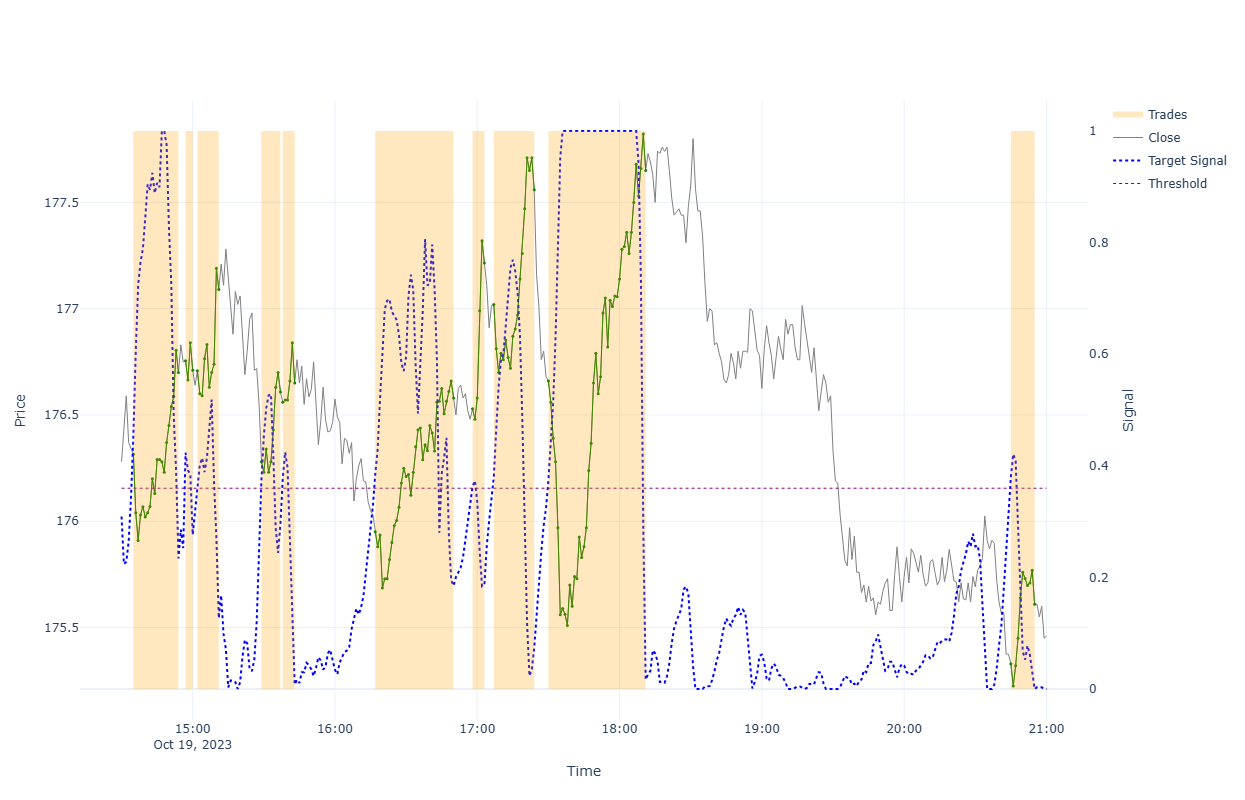

  Buy & Hold Return ($): -0.996
  Strategy Return ($): 2.499
  Trades Returns ($): [0.208, -0.221, 0.205, 0.152, -0.087, 0.452, 0.509, 0.363, 0.813, 0.105]
-------------------------------------------------------------------------------------------------------------------------------------------------


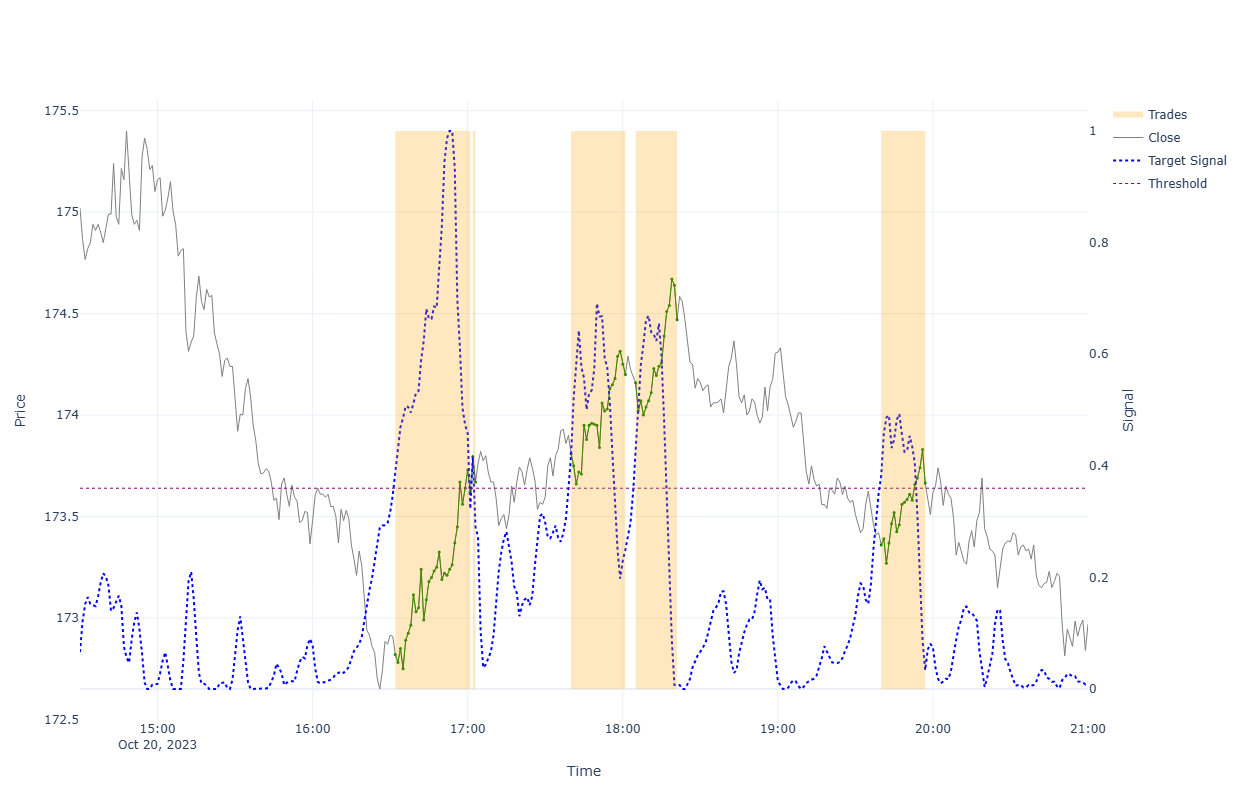

  Buy & Hold Return ($): -2.224
  Strategy Return ($): 0.817
  Trades Returns ($): [0.631, -0.299, 0.216, 0.138, 0.132]
-------------------------------------------------------------------------------------------------------------------------------------------------


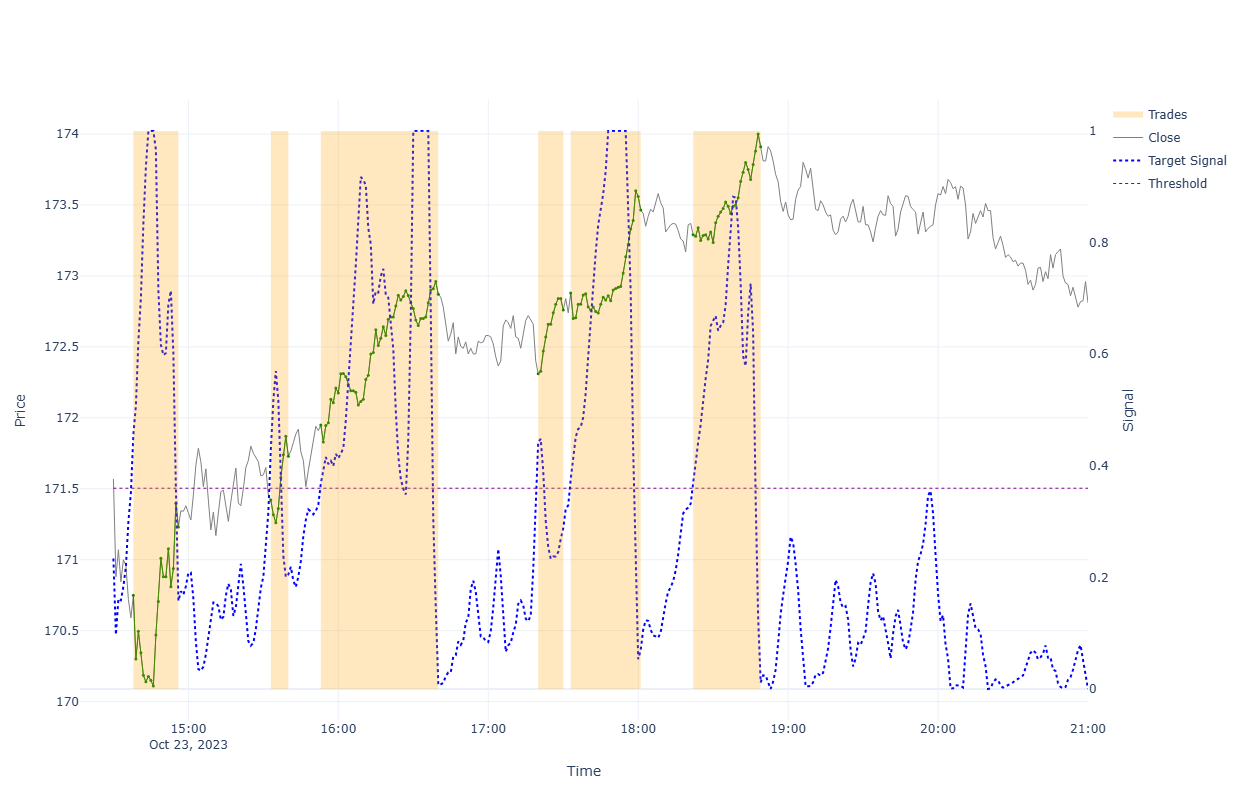

  Buy & Hold Return ($): 1.068
  Strategy Return ($): 2.331
  Trades Returns ($): [0.309, 0.139, 0.748, 0.278, 0.412, 0.446]
-------------------------------------------------------------------------------------------------------------------------------------------------


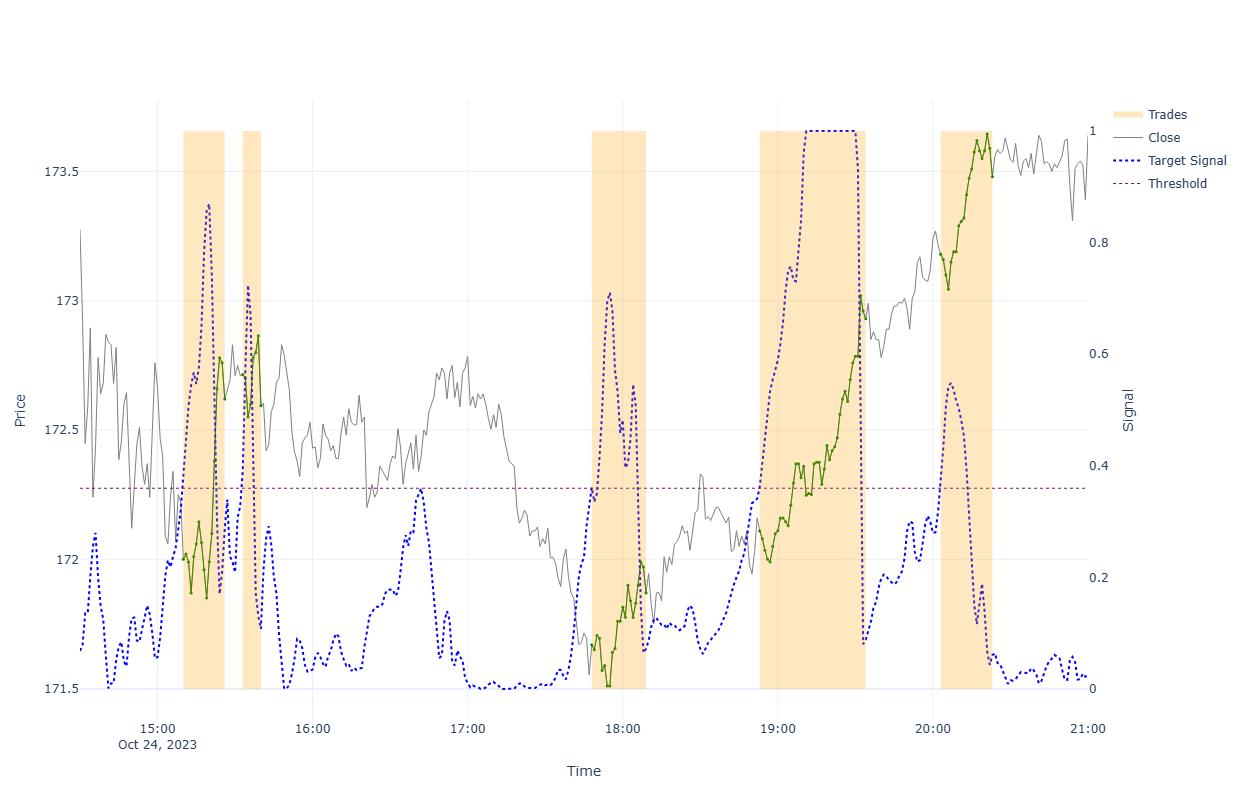

  Buy & Hold Return ($): 0.19
  Strategy Return ($): 0.957
  Trades Returns ($): [0.447, -0.294, 0.027, 0.647, 0.126]
-------------------------------------------------------------------------------------------------------------------------------------------------


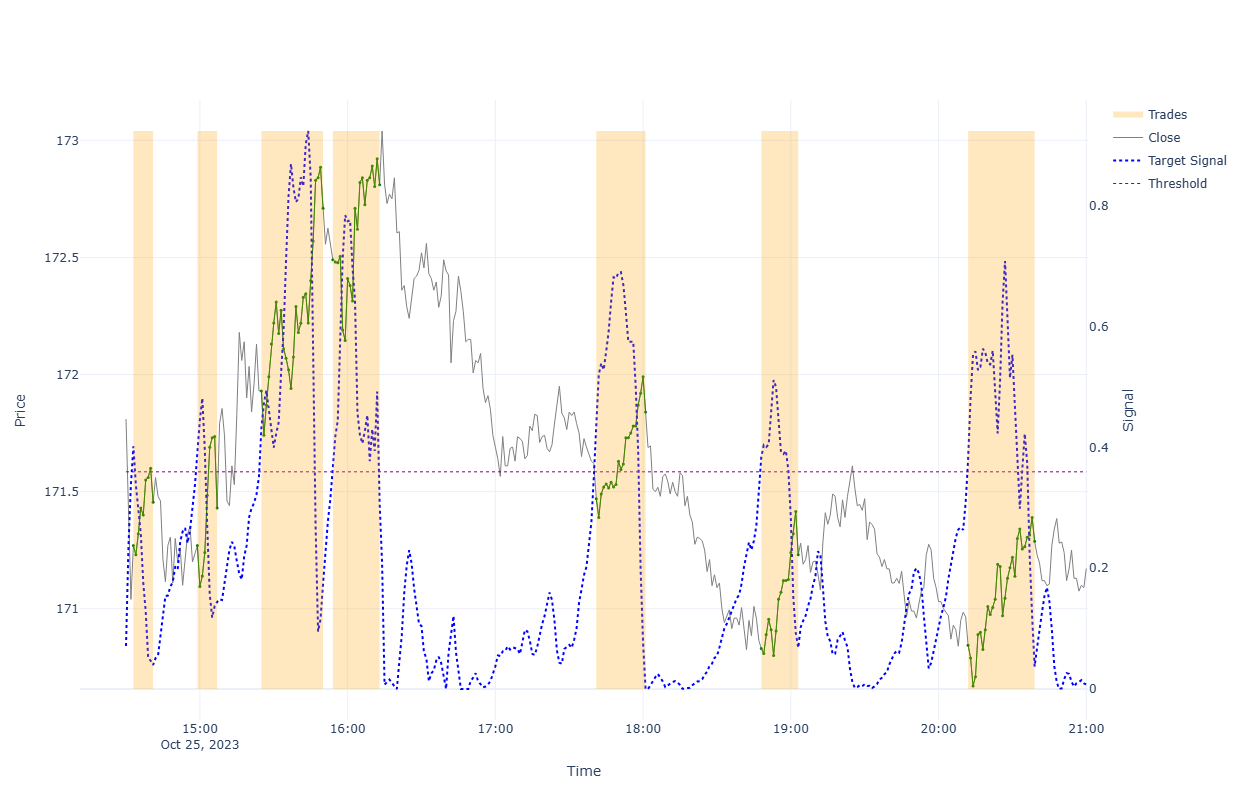

  Buy & Hold Return ($): -0.81
  Strategy Return ($): 1.458
  Trades Returns ($): [0.014, -0.012, 0.607, 0.148, 0.199, 0.229, 0.273]
-------------------------------------------------------------------------------------------------------------------------------------------------


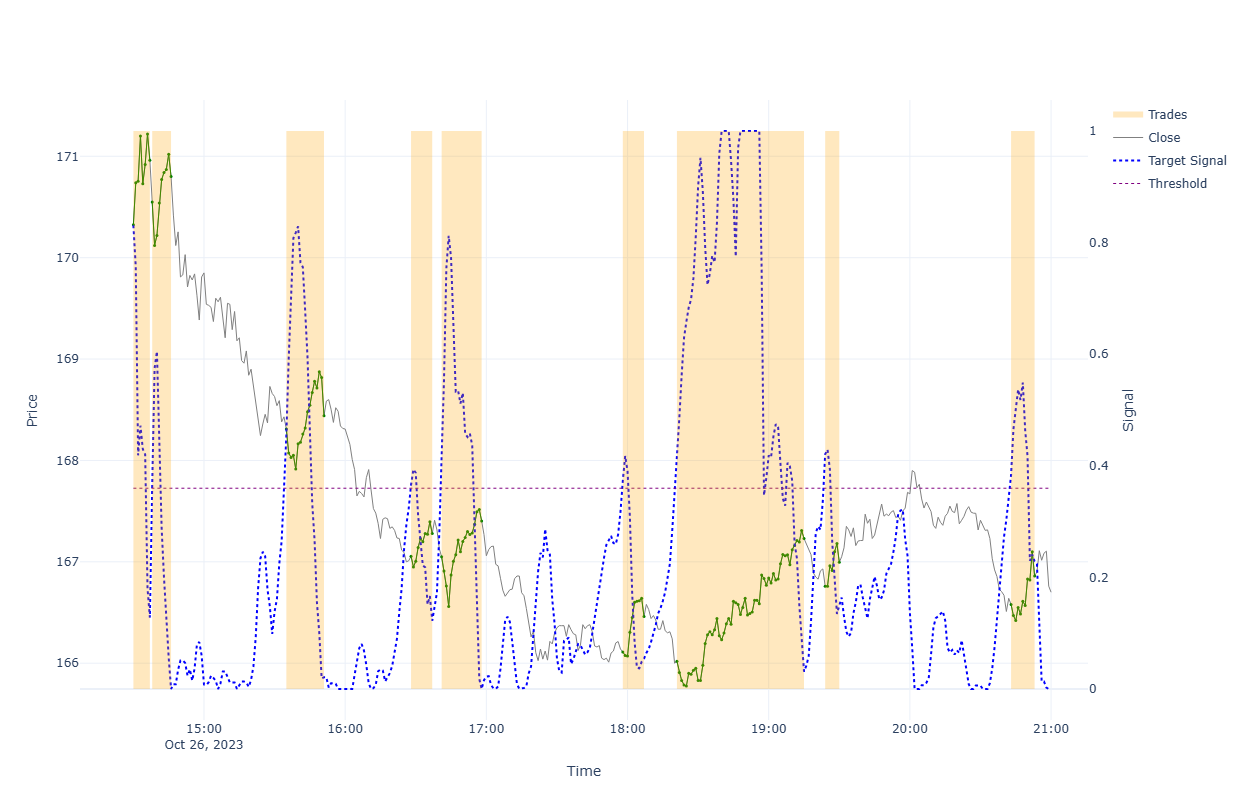

  Buy & Hold Return ($): -3.794
  Strategy Return ($): 2.156
  Trades Returns ($): [0.464, 0.078, -0.039, 0.057, 0.186, 0.184, 1.043, 0.068, 0.113]
-------------------------------------------------------------------------------------------------------------------------------------------------


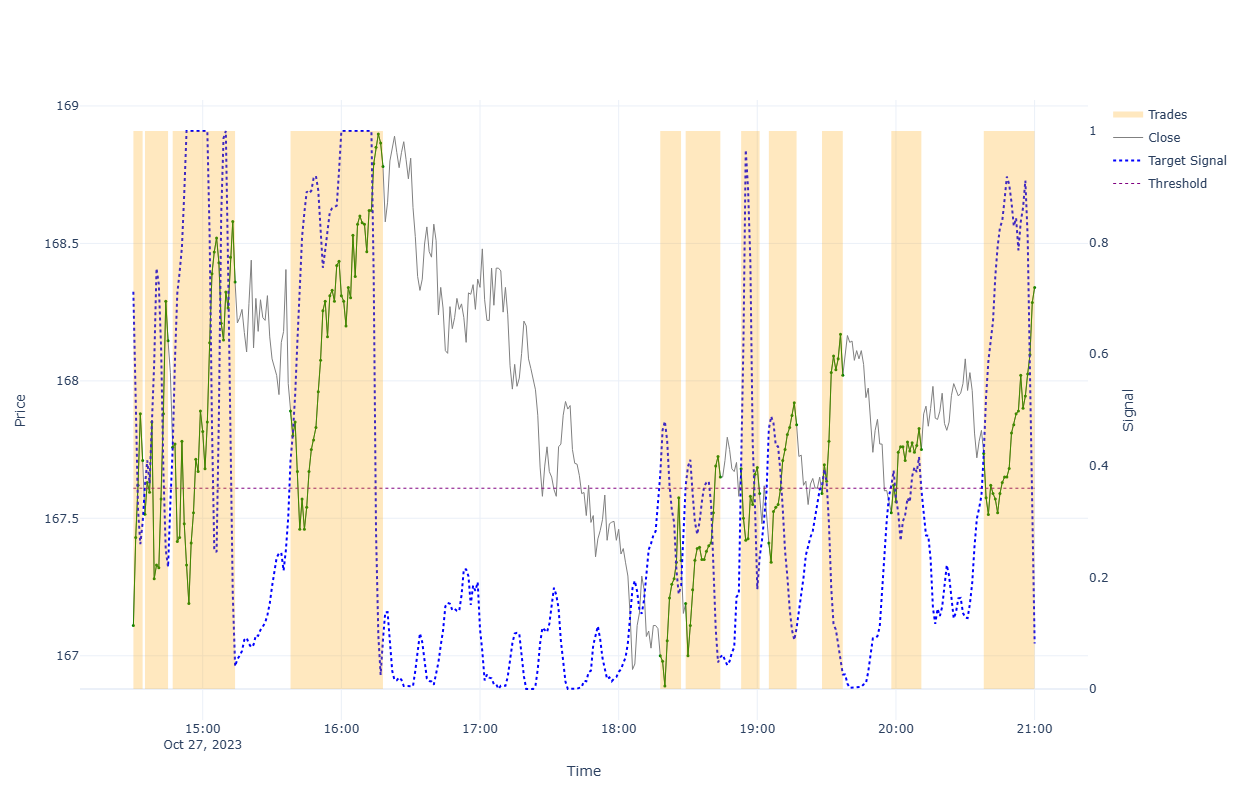

  Buy & Hold Return ($): 1.062
  Strategy Return ($): 3.287
  Trades Returns ($): [0.433, 0.463, 0.433, 0.722, 0.179, 0.293, -0.258, 0.263, 0.262, 0.062, 0.436]
-------------------------------------------------------------------------------------------------------------------------------------------------


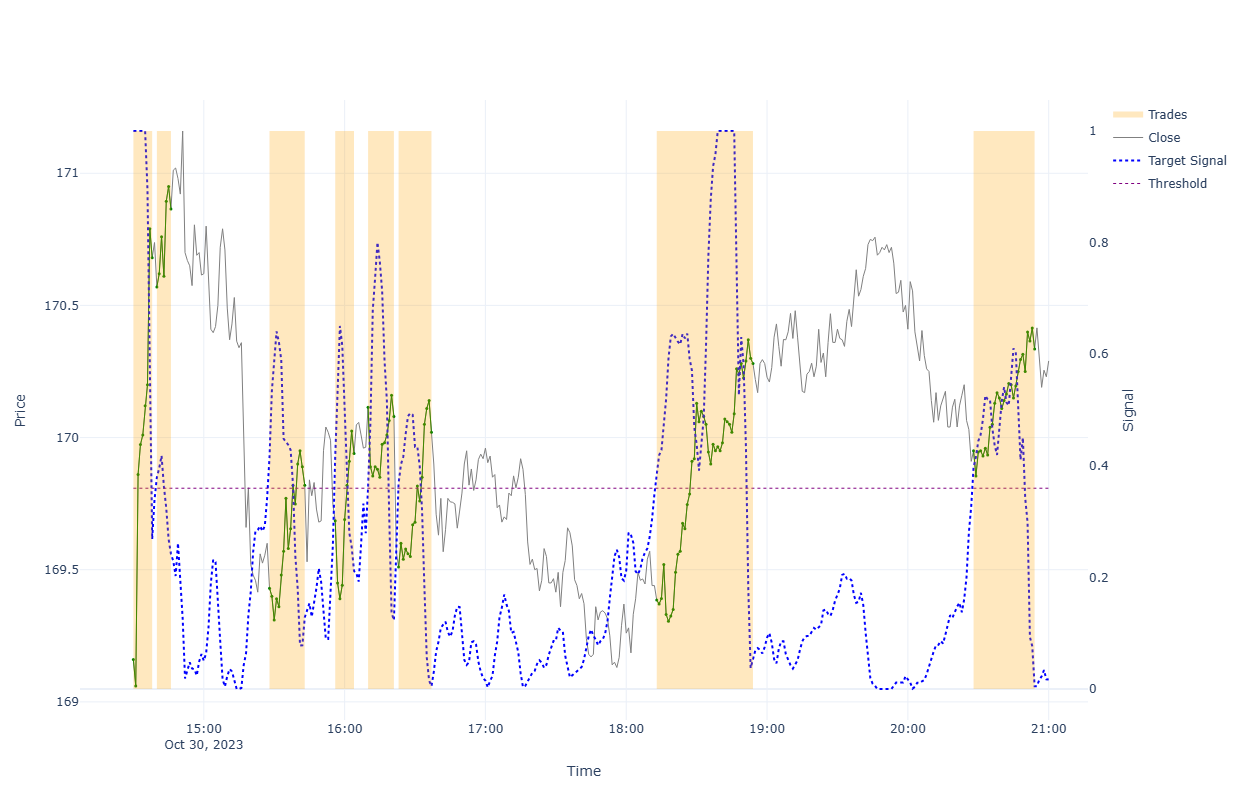

  Buy & Hold Return ($): 0.96
  Strategy Return ($): 2.855
  Trades Returns ($): [1.351, 0.125, 0.22, 0.085, -0.206, 0.341, 0.725, 0.214]
-------------------------------------------------------------------------------------------------------------------------------------------------


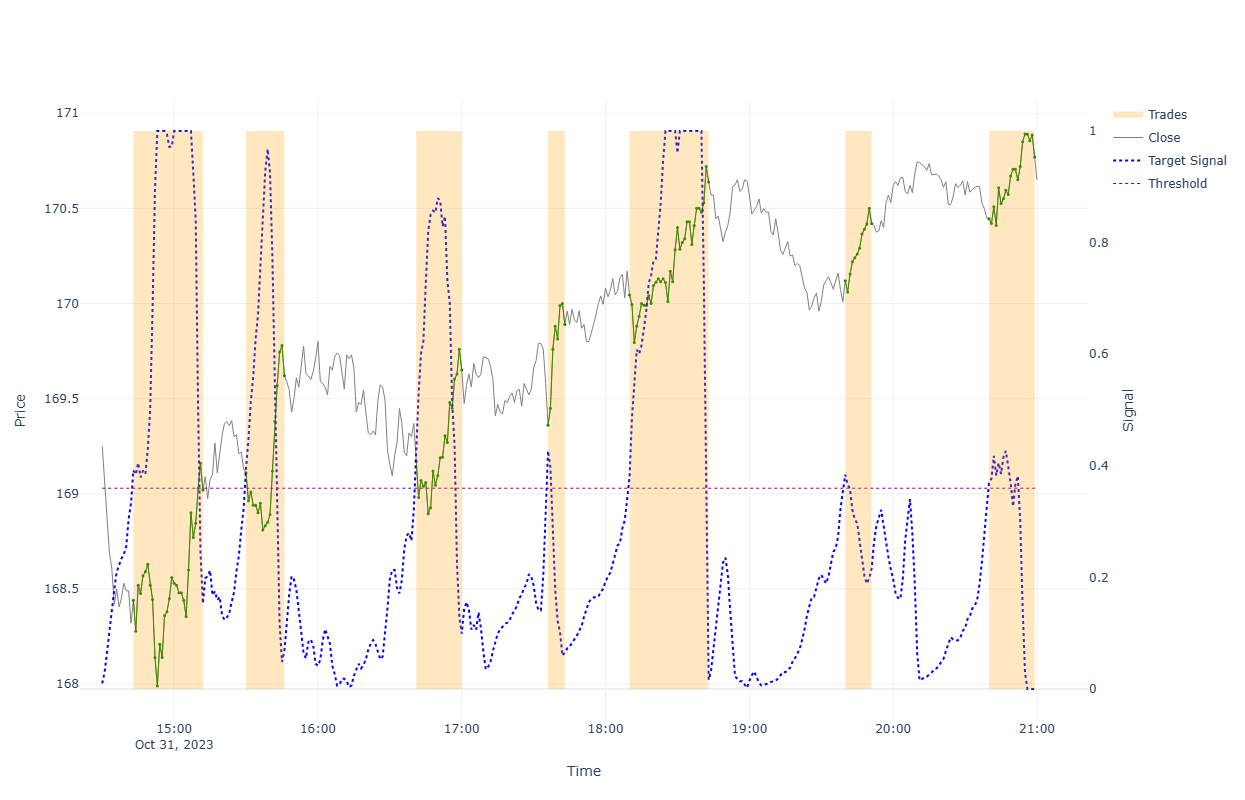

  Buy & Hold Return ($): 1.23
  Strategy Return ($): 2.128
  Trades Returns ($): [0.411, 0.34, 0.31, 0.361, 0.424, 0.129, 0.153]

Overall Summary (2023-10-02 = 171.1956 → 2023-10-31 = 170.5647)

One-time buy&hold gain: -0.631
Buy & Hold – each day ($): 6.102
Strategy Return ($): 49.007
Trades Count: 150
Strategy return per trade: 0.327
Num. trading days: 22
Strategy return per trading day: 2.228


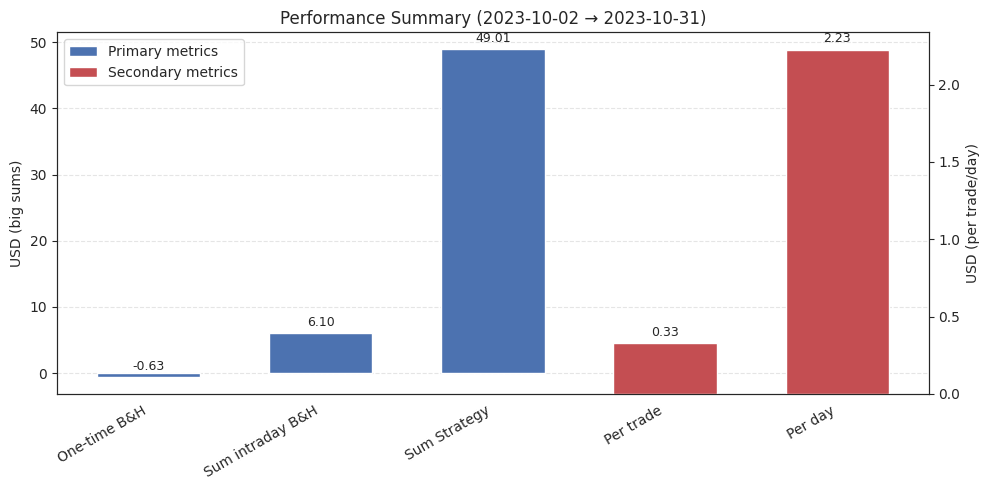


******************** Running pipeline on full dataset ********************
Detecting & merging trades by day …
Computing raw continuous signals …
Scale & cap the smoothed signal ( top & bottom percentiles set at 5.78 ) & generating trade actions …


Simulating trading days: 100%|██████████| 5400/5400 [02:25<00:00, 37.16day/s]



Overall Summary (2004-01-02 = 0.7729 → 2025-06-18 = 196.4417)

One-time buy&hold gain: 195.669
Buy & Hold – each day ($): -238.539
Strategy Return ($): 4448.042
Trades Count: 35550
Strategy return per trade: 0.125
Num. trading days: 5400
Strategy return per trading day: 0.824


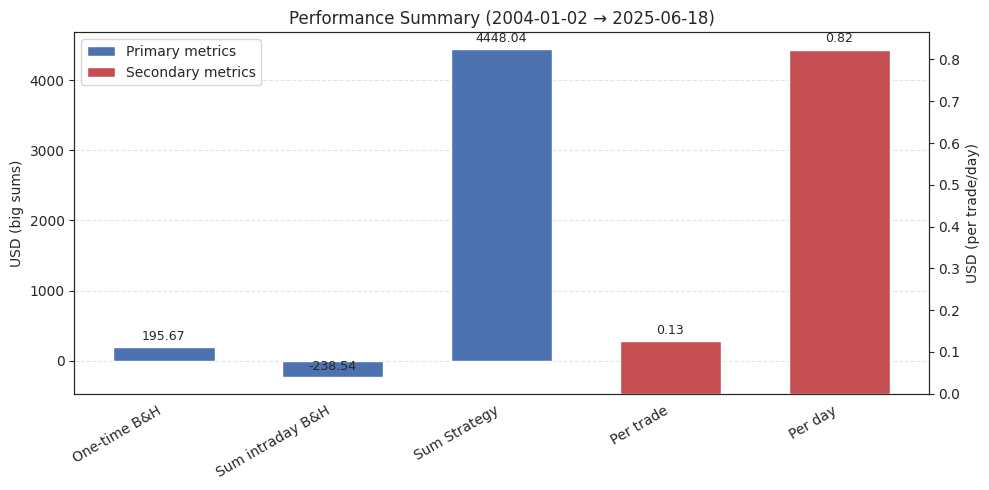


Overall Summary (2022-03-28 = 172.7863 → 2025-06-18 = 196.4417)

One-time buy&hold gain: 23.655
Buy & Hold – each day ($): -114.749
Strategy Return ($): 2214.880
Trades Count: 5223
Strategy return per trade: 0.424
Num. trading days: 810
Strategy return per trading day: 2.734


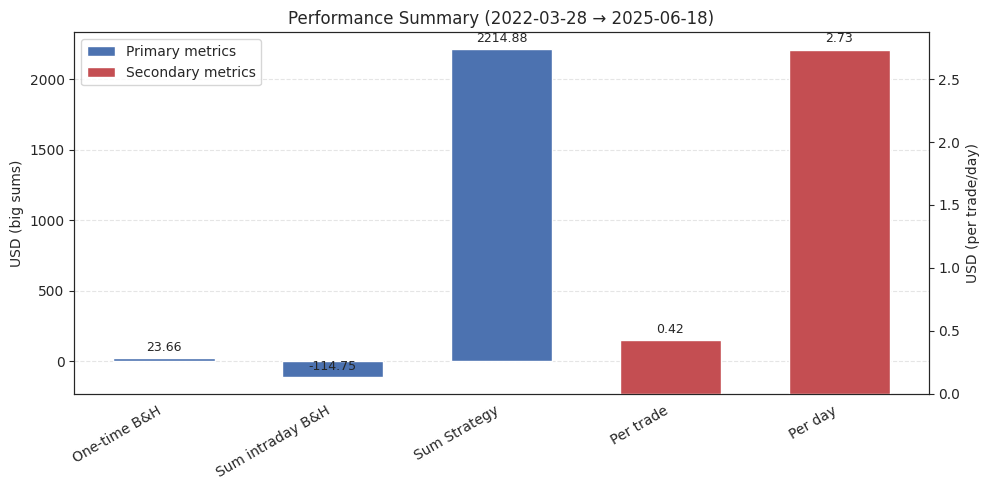


Saving full-run signals to dfs/AAPL_2_sign.csv …
CSV saved.


open        high         low       close  \
2004-01-02 09:00:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:01:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:02:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:03:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:04:00    0.764286    0.764286    0.764286    0.764286   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  196.680000  196.860000  196.630000  196.815000   
2025-06-18 20:57:00  196.810000  196.940000  196.560000  196.675000   
2025-06-18 20:58:00  196.675000  196.740000  196.630000  196.670000   
2025-06-18 20:59:00  196.680000  196.750000  196.240000  196.240000   
2025-06-18 21:00:00  196.580000  196.650000  196.080000  196.540000   

                         volume         ask         bid    signal_raw  \
2004-01-02 09:00:00     28000.0    0.764668    0.763904  8.501171e-14   
2004-01-02 09:01:00     28000.0    0.764668    0.763904  9.130610e-14   
2004-01-02 09:02:00     28000.0    0.764668    0.763904  9.806653e-14   
2004-01-02 09:03:00     28000.0    0.764668    0.763904  1.053275e-13   
2004-01-02 09:04:00     28000.0    0.764668    0.763904  1.131261e-13   
...                         ...         ...         ...           ...   
2025-06-18 20:56:00    385695.0  196.913400  196.716600  0.000000e+00   
2025-06-18 20:57:00    460630.0  196.773300  196.576700  0.000000e+00   
2025-06-18 20:58:00    525245.0  196.768300  196.571700  0.000000e+00   
2025-06-18 20:59:00   2075503.0  196.338100  196.141900  7.159585e-06   
2025-06-18 21:00:00  15600625.0  196.638300  196.441700  0.000000e+00   

                           signal  signal_action  Position     Cash  NetValue  \
2004-01-02 09:00:00  6.086916e-10              0         0    0.000      0.00   
2004-01-02 09:01:00  6.314940e-10              0         0    0.000      0.00   
2004-01-02 09:02:00  6.782507e-10              0         0    0.000      0.00   
2004-01-02 09:03:00  7.284694e-10              0         0    0.000      0.00   
2004-01-02 09:04:00  7.824063e-10              0         0    0.000      0.00   
...                           ...            ...       ...      ...       ...   
2025-06-18 20:56:00  1.794683e-01              0         1 -193.047      3.67   
2025-06-18 20:57:00  0.000000e+00             -1         0    3.530      3.53   
2025-06-18 20:58:00  1.647774e-02              0         0    3.530      3.53   
2025-06-18 20:59:00  1.647774e-02              0         0    3.530      3.53   
2025-06-18 21:00:00  2.471661e-02              0         0    3.530      3.53   

                       Action  TradedAmount  BuyHoldEarning  StrategyEarning  \
2004-01-02 09:00:00  No trade             0           0.000             0.00   
2004-01-02 09:01:00  No trade             0           0.000             0.00   
2004-01-02 09:02:00  No trade             0           0.000             0.00   
2004-01-02 09:03:00  No trade             0           0.000             0.00   
2004-01-02 09:04:00  No trade             0           0.000             0.00   
...                       ...           ...             ...              ...   
2025-06-18 20:56:00      Hold             0           0.699             3.67   
2025-06-18 20:57:00      Sell            -1           0.559             3.53   
2025-06-18 20:58:00      Hold             0           0.554             3.53   
2025-06-18 20:59:00      Hold             0           0.124             3.53   
2025-06-18 21:00:00  No trade             0           0.424             3.53   

                     EarningDiff  
2004-01-02 09:00:00        0.000  
2004-01-02 09:01:00        0.000  
2004-01-02 09:02:00        0.000  
2004-01-02 09:03:00        0.000  
2004-01-02 09:04:00        0.000  
...                          ...  
2025-06-18 20:56:00        2.971  
2025-06-18 20:57:00        2.971  
2025-06-18 20:58:00        2.976  
2025-06-18 20

In [5]:
print('best_optuna_value:', params.best_optuna_value)
print('best_optuna_params:', params.best_optuna_params)

df_fin = saveDF_checkDAY(
                        df=df,
                        best_optuna_params=params.best_optuna_params
                        )

df_fin

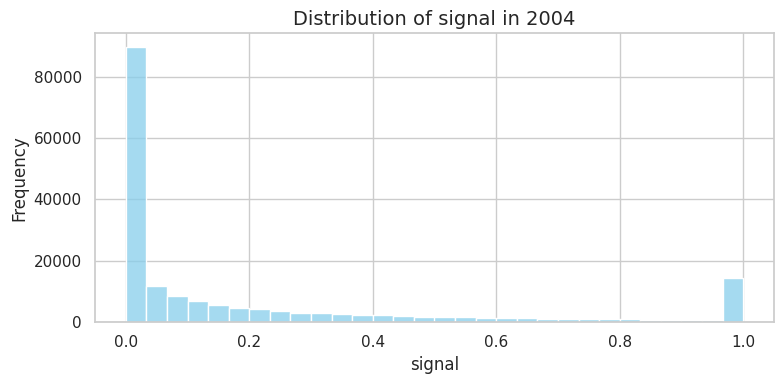

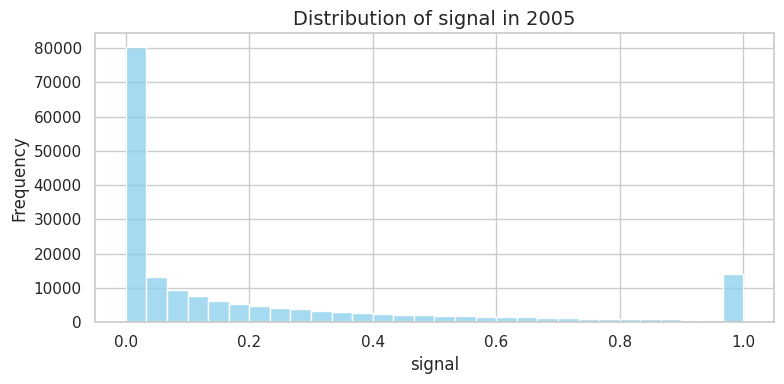

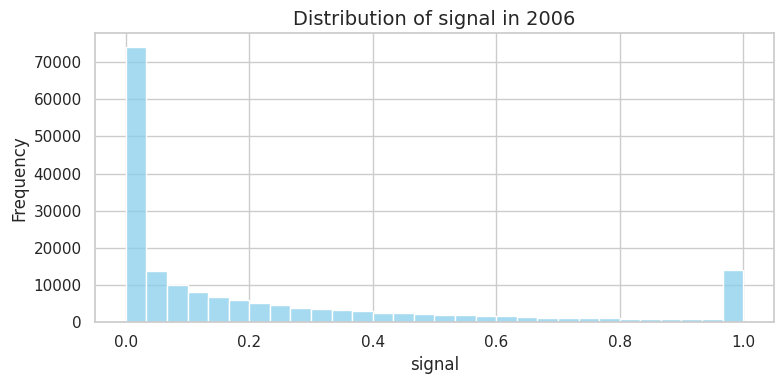

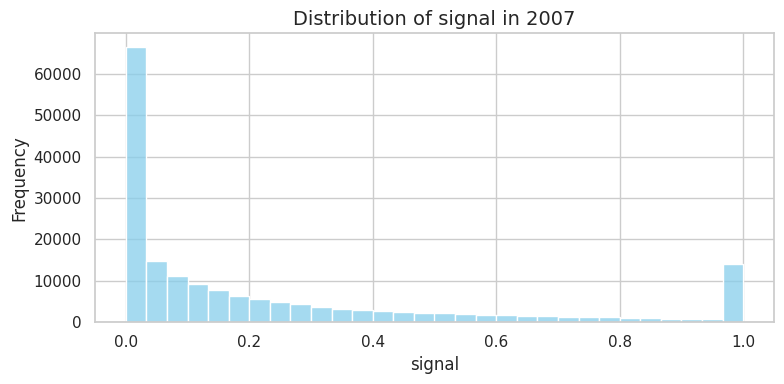

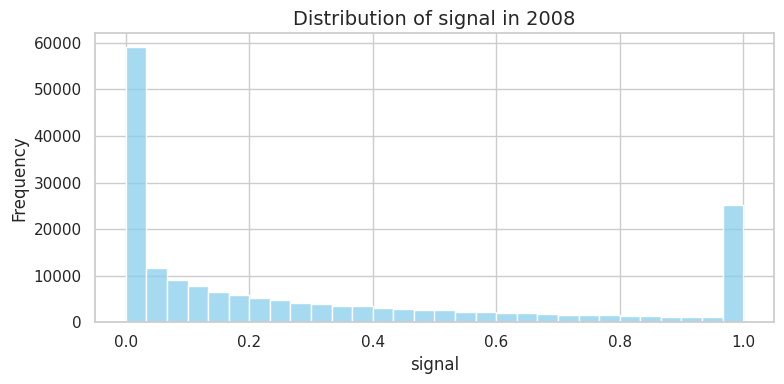

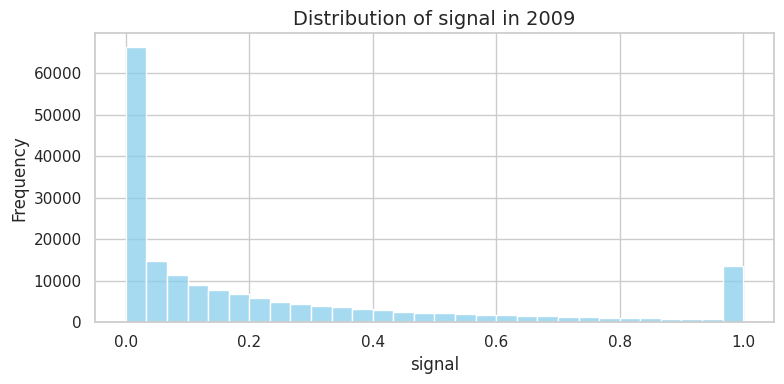

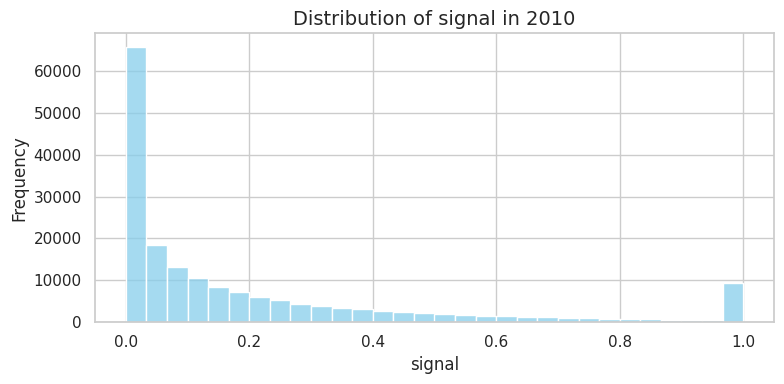

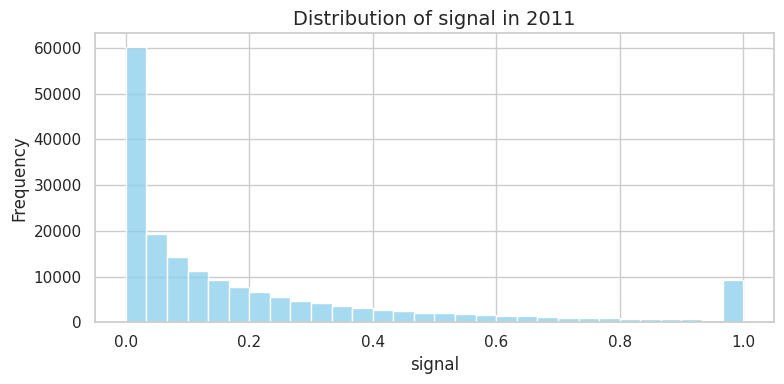

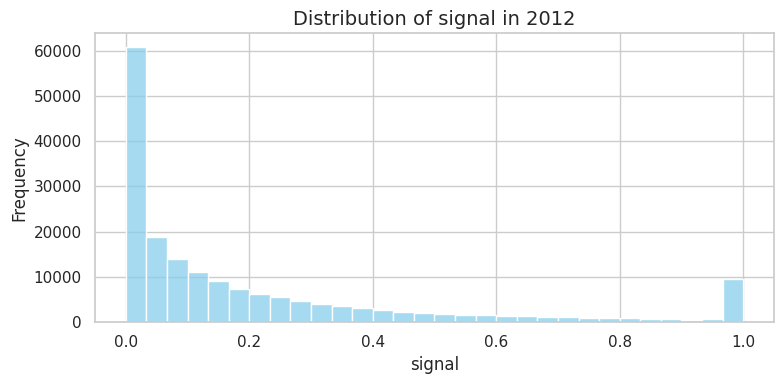

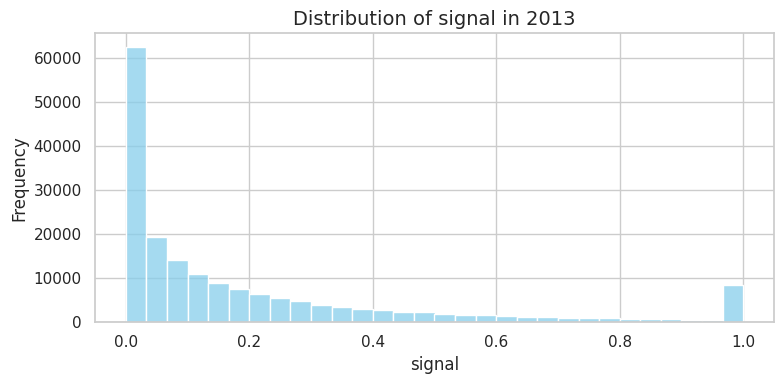

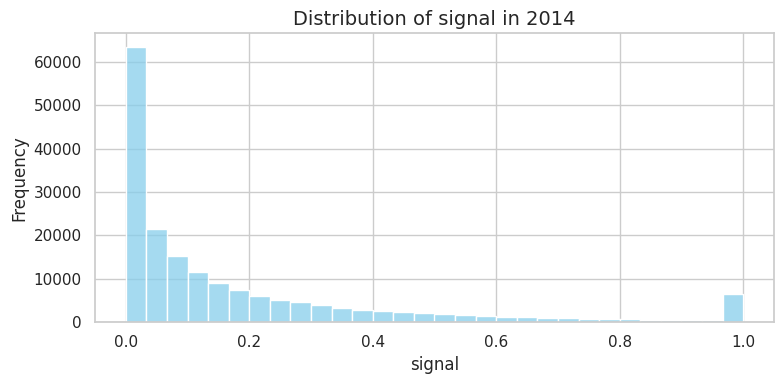

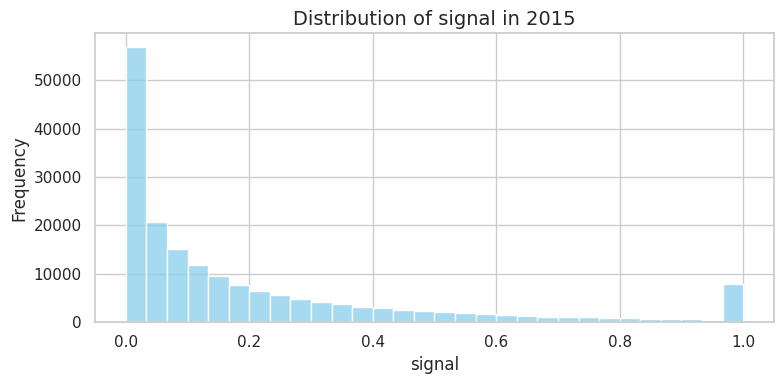

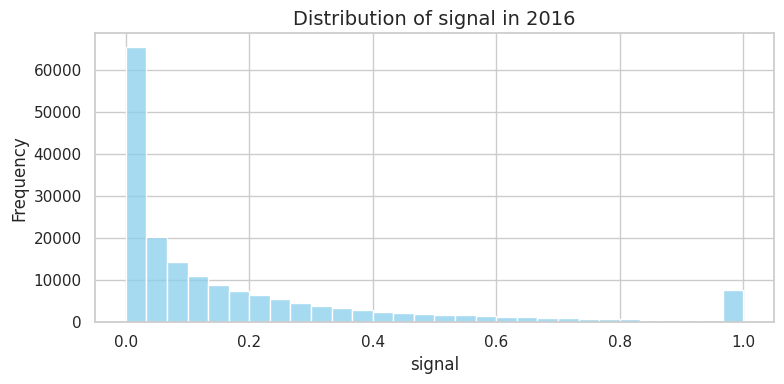

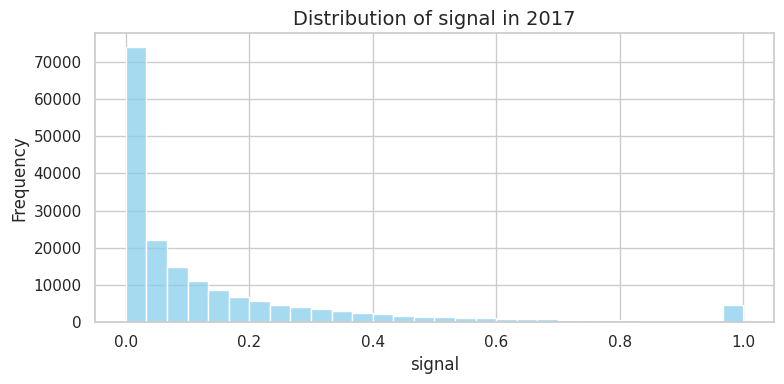

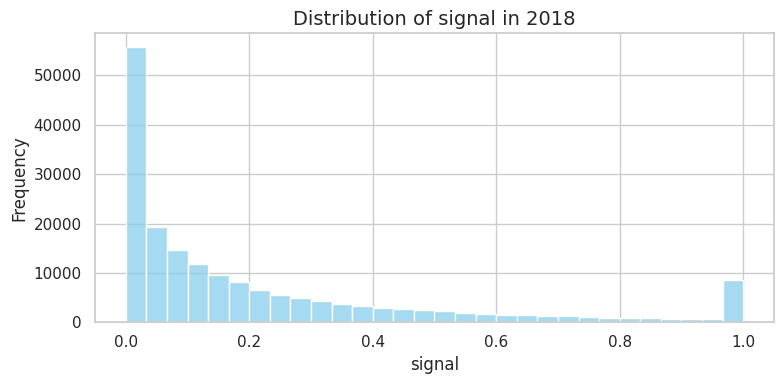

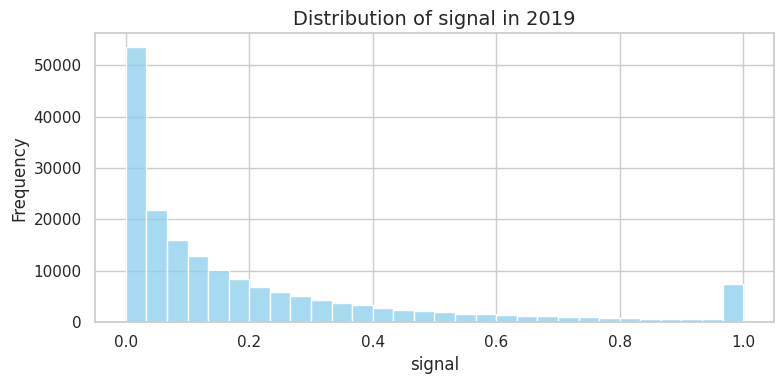

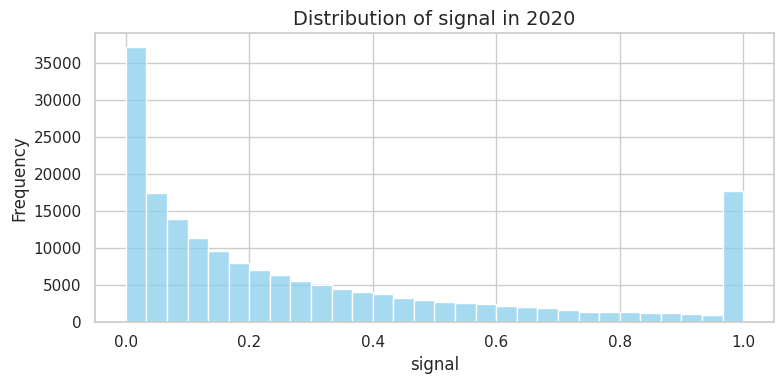

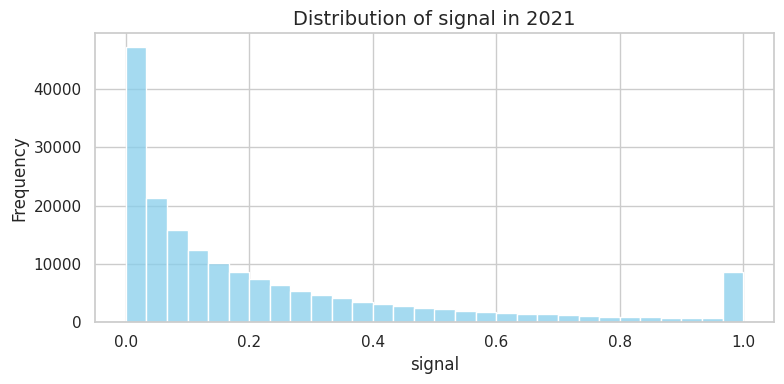

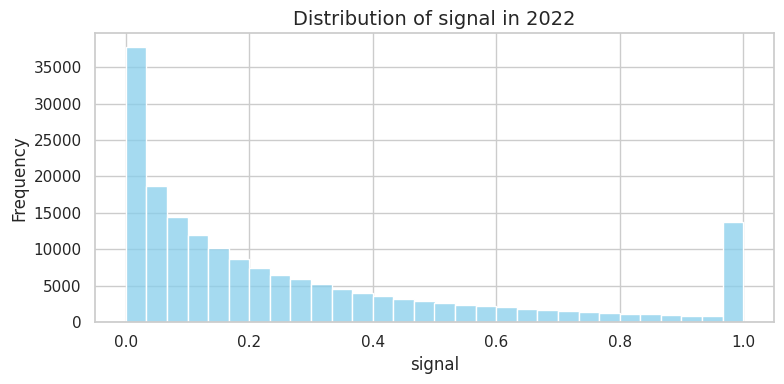

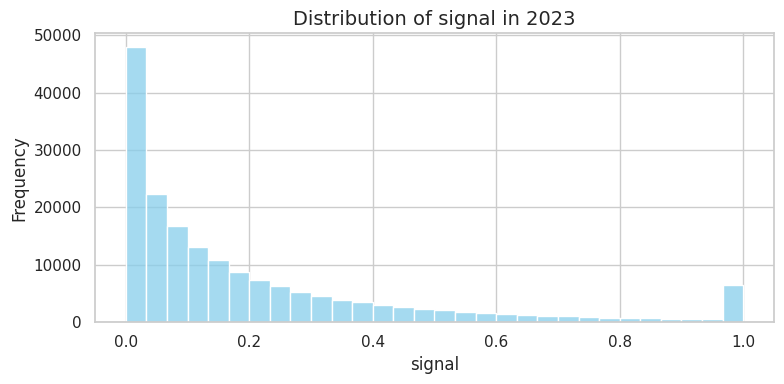

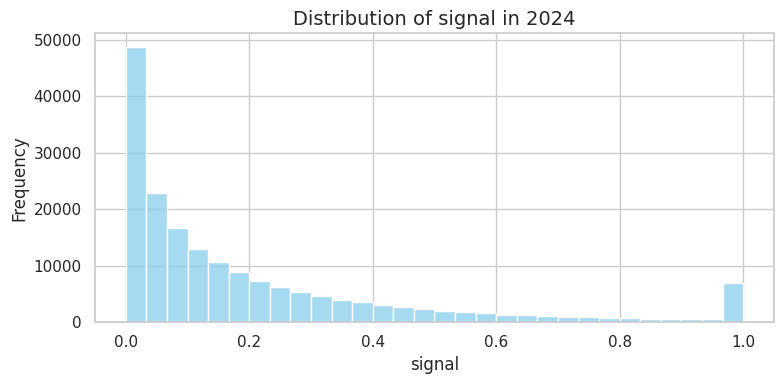

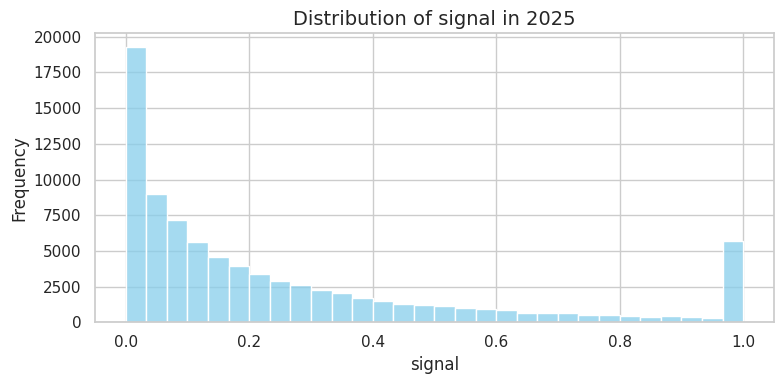

signal_min  signal_max  signal_mean  signal_median  close_return
2004-01         0.0         1.0     0.206858       0.041448      0.170916
2004-02         0.0         1.0     0.178566       0.023975      0.105893
2004-03         0.0         1.0     0.216513       0.037240      0.196335
2004-04         0.0         1.0     0.197732       0.025544      0.156863
2004-05         0.0         1.0     0.206663       0.027863      0.127743
2004-06         0.0         1.0     0.208198       0.036335      0.241579
2004-07         0.0         1.0     0.210965       0.038162      0.161862
2004-08         0.0         1.0     0.201742       0.024484      0.182185
2004-09         0.0         1.0     0.202087       0.031337      0.145439
2004-10         0.0         1.0     0.222388       0.050038      0.409440
2004-11         0.0         1.0     0.220458       0.048021      0.333589
2004-12         0.0         1.0     0.196463       0.050825      0.101071
2005-01         0.0         1.0     0.237691       0.068463      0.243334
2005-02         0.0         1.0     0.227245       0.070446      1.067515
2005-03         0.0         1.0     0.219762       0.061608      0.160576
2005-04         0.0         1.0     0.252053       0.070359      0.295820
2005-05         0.0         1.0     0.222138       0.061013      0.234620
2005-06         0.0         1.0     0.198959       0.042269      0.145751
2005-07         0.0         1.0     0.202555       0.057643      0.222039
2005-08         0.0         1.0     0.187203       0.039409      0.143297
2005-09         0.0         1.0     0.203748       0.049501      0.183041
2005-10         0.0         1.0     0.264304       0.085885      0.240634
2005-11         0.0         1.0     0.205164       0.059222      0.246400
2005-12         0.0         1.0     0.206568       0.065096      0.117481
2006-01         0.0         1.0     0.280971       0.113140      0.216178
2006-02         0.0         1.0     0.250610       0.085323      0.213435
2006-03         0.0         1.0     0.226587       0.072116      0.212021
2006-04         0.0         1.0     0.231954       0.072934      0.186985
2006-05         0.0         1.0     0.201036       0.060486      0.247914
2006-06         0.0         1.0     0.225997       0.071725      0.137473
2006-07         0.0         1.0     0.245191       0.079471      0.358532
2006-08         0.0         1.0     0.233529       0.080607      0.123615
2006-09         0.0         1.0     0.238023       0.093197      0.150496
2006-10         0.0         1.0     0.189623       0.057295      0.136044
2006-11         0.0         1.0     0.199049       0.064287      0.205850
2006-12         0.0         1.0     0.207469       0.065258      0.199142
2007-01         0.0         1.0     0.240214       0.099124      0.192073
2007-02         0.0         1.0     0.183201       0.059835      0.094767
2007-03         0.0         1.0     0.183907       0.061328      0.156511
2007-04         0.0         1.0     0.177959       0.054939      0.167337
2007-05         0.0         1.0     0.215569       0.081023      0.238485
2007-06         0.0         1.0     0.232273       0.095399      0.102931
2007-07         0.0         1.0     0.250383       0.106758      0.245818
2007-08         0.0         1.0     0.282107       0.127195      0.247318
2007-09         0.0         1.0     0.251603       0.107894      0.193898
2007-10         0.0         1.0     0.247061       0.106940      0.244270
2007-11         0.0         1.0     0.323599       0.151676      0.274720
2007-12         0.0         1.0     0.254400       0.113417      0.151206
2008-01         0.0         1.0     0.327595       0.161738      0.585735
2008-02         0.0         1.0     0.287627       0.141772      0.188922
2008-03         0.0         1.0     0.322045       0.151411      0.233486
2008-04         0.0         1.0     0.286692       0.147854      0.240805
2008-05         0.0         1.0     0.250778       0.114072      0.112945
2008-06      

In [6]:
pd.set_option('display.max_rows', None)

# Group by month
period = df_fin.index.to_period('M')

# Monthly stats for signal
signal_stats = df_fin.groupby(period)['signal'].agg(
    signal_min='min',
    signal_max='max',
    signal_mean='mean',
    signal_median='median'
)

# Monthly close return: (max - min) / min
close_return = df_fin.groupby(period)['close'].agg(
    close_return=lambda x: np.nan if x.min() == 0 else (x.max() - x.min()) / x.min()
)

# Combine into one DataFrame
monthly_stats = signal_stats.join(close_return)


# --------------------------------------------------
# Now plot histograms of signal for each year
# --------------------------------------------------

sns.set(style="whitegrid")
unique_years = sorted(df_fin.index.year.unique())

for y in unique_years:
    subset = df_fin[df_fin.index.year == y]['signal']
    
    plt.figure(figsize=(8, 4))
    sns.histplot(subset, bins=30, kde=False, color="skyblue")
    plt.title(f"Distribution of signal in {y}", fontsize=14)
    plt.xlabel("signal", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    plt.show()

monthly_stats
